# Исследовательский анализ бизнес-показателей маркетплейса

- Автор: Сикорская Ярослава
- Дата: 06.12.2025

### Задачи
1. Оценка ключевых метрик продукта и метрик монетизации
2. Поиск точек роста и инсайтов
3. Проведение А/В эксперимента

### План проекта

1. Загрузка данных и их предобработка.
2. Обзор ключевых метрик.
3. Оценка метрик монетизации и юнит-экономики.
4. Поиск инсайтов и точек роста. Сегментация и формулирование гипотез.
5. Подготовка эксперимента и подведение его итогов.


#### ВАЖНОЕ: выручка маркетплейса - 5% комиссии с total_price


## 1.Загрузка данных и их предобработка
Выгрузим полученные данные и получим основную информацию о них. После чего проведем предобработку и зафиксируем результаты в промежуточном выводе.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
!pip install matplotlib-venn
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [2]:
#Выгрузим необходимую информацию в переменные
users_df = pd.read_csv('./data/pa_marketplace_users.csv', parse_dates=['registration_date', 'cohort_week', 'cohort_month'])
orders_df = pd.read_csv('./data/pa_marketplace_orders.csv', parse_dates=['order_date', 'order_week', 'order_month'])
events_df = pd.read_csv('./data/pa_marketplace_events.csv', parse_dates=['event_date', 'event_week', 'event_month'])
campaign_costs = pd.read_csv('./data/pa_marketplace_campaign_costs.csv', parse_dates=['spend_month'])

Посмотрим, какие данные содержатся в датафрейме с информацией о пользователях users_df:

In [3]:
#Выведем первые строки датафрейма
users_df.head()

,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month
0,1,2024-01-01 00:47:00,35,M,Москва,Google Ads,regular,2024-01-01,2024-01-01
1,2,2024-01-01 19:01:00,53,M,Москва,Email Marketing,rare,2024-01-01,2024-01-01
2,3,2024-01-01 04:13:00,66,F,Санкт-Петербург,Google Ads,regular,2024-01-01,2024-01-01
3,4,2024-01-01 17:18:00,58,M,Краснодар,Affiliate,one_time,2024-01-01,2024-01-01
4,5,2024-01-01 08:29:00,58,F,Другие регионы,Google Ads,regular,2024-01-01,2024-01-01


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44151 entries, 0 to 44150
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            44151 non-null  int64         
 1   registration_date  44151 non-null  datetime64[ns]
 2   age                44151 non-null  int64         
 3   gender             44151 non-null  object        
 4   region             44151 non-null  object        
 5   acq_channel        44151 non-null  object        
 6   buyer_segment      44151 non-null  object        
 7   cohort_week        44151 non-null  datetime64[ns]
 8   cohort_month       44151 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 3.0+ MB


In [5]:
print(f'Количество явных дубликатов в датафрейме users_df: {users_df.duplicated().sum()}')

#Выясним, какие категориальные данные у нас хранятся в датафрейме
region_unique = users_df['region'].unique()
channel_unique = users_df['acq_channel'].unique()
segment_unique = users_df['buyer_segment'].unique()
age_min = users_df['age'].min()
age_max = users_df['age'].max()
print(f'В датасете представлено:\n'
      f'- регионы пользователей -{region_unique};\n',
      f'- каналы привлечения - {channel_unique};\n',
      f'- сегменты покупателей - {segment_unique};\n',
      f'- диапазон возраста: {age_min} - {age_max}.')

Количество явных дубликатов в датафрейме users_df: 0
В датасете представлено:
- регионы пользователей -['Москва' 'Санкт-Петербург' 'Краснодар' 'Другие регионы' 'Нижний Новгород'
 'Екатеринбург' 'Московская область' 'Новосибирск' 'Ростов-на-Дону'];
 - каналы привлечения - ['Google Ads' 'Email Marketing' 'Affiliate' 'SEO' 'Social Media' 'TikTok'];
 - сегменты покупателей - ['regular' 'rare' 'one_time' 'medium'];
 - диапазон возраста: 18 - 70.


Теперь изучим датафрейм с заказами пользователей orders_df:

In [6]:
#Выведем первые строки датафрейма
orders_df.head()

,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
0,1,3,2024-01-19 01:52:52,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
1,2,3,2024-01-19 01:52:52,Молоток слесарный,1,11340.38,11340.38,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
2,3,3,2024-01-19 01:52:52,Секатор садовый,2,10892.09,21784.18,Инструменты и садовый инвентарь,2024-01-15,2024-01-01
3,4,3,2024-01-25 13:59:38,Шуруповерт,2,5539.13,11078.26,Инструменты и садовый инвентарь,2024-01-22,2024-01-01
4,5,3,2024-01-25 13:59:38,Чай черный,1,2099.59,2099.59,Продукты питания,2024-01-22,2024-01-01


In [7]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31357 entries, 0 to 31356
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       31357 non-null  int64         
 1   user_id        31357 non-null  int64         
 2   order_date     31357 non-null  datetime64[ns]
 3   product_name   31357 non-null  object        
 4   quantity       31357 non-null  int64         
 5   unit_price     31357 non-null  float64       
 6   total_price    31357 non-null  float64       
 7   category_name  31357 non-null  object        
 8   order_week     31357 non-null  datetime64[ns]
 9   order_month    31357 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 2.4+ MB


In [8]:
print(f'Количество явных дубликатов в датафрейме orders_df: {orders_df.duplicated().sum()}')

#Выясним, какие данные у нас хранятся в датафрейме
category_name_unique = orders_df['category_name'].unique()
quantity_unique = orders_df['quantity'].unique()
min_price = orders_df['unit_price'].min()
max_price = orders_df['unit_price'].max()
print(f'В датасете представлено:\n'
      f'- категории товаров - {category_name_unique}\n',
      f'- количество заказанного товара - {quantity_unique}\n',
      f'- диапазон цен на товары: {min_price} - {max_price}.')

Количество явных дубликатов в датафрейме orders_df: 0
В датасете представлено:
- категории товаров - ['Инструменты и садовый инвентарь' 'Продукты питания' 'Женская одежда'
 'Аксессуары для гаджетов' 'Одежда для спорта' 'Декор и освещение'
 'Детская одежда' 'Детские игрушки' 'Книги и канцтовары'
 'Медицинские товары' 'Косметика и парфюмерия' 'Товары для туризма'
 'Сумки и аксессуары' 'Автотовары' 'Обувь мужская' 'Обувь женская'
 'Мужская одежда' 'Бытовая техника' 'Зоотовары' 'Товары для кухни'
 'Средства для ухода' 'Мебель для дома' 'Спортивный инвентарь'
 'Товары для новорожденных' 'Украшения и часы']
 - количество заказанного товара - [2 1 3]
 - диапазон цен на товары: 339.0 - 63932.38.


Посмотрим на датафрейм с событиями пользователей events_df:

In [9]:
events_df.head()

,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month
0,3132,100,2024-01-01,page_view,iOS,mobile,NaN,2024-01-01,2024-01-01
1,3133,100,2024-01-01,product_view,iOS,mobile,Шорты для тренировок,2024-01-01,2024-01-01
2,3134,100,2024-01-01,product_click,iOS,mobile,Куртка детская,2024-01-01,2024-01-01
3,3135,100,2024-01-01,add_to_cart,iOS,mobile,Балетки классические,2024-01-01,2024-01-01
4,3136,100,2024-01-01,checkout_start,iOS,mobile,NaN,2024-01-01,2024-01-01


In [10]:
events_df.info()
print(f'Количество явных дубликатов в датафрейме events_df: {events_df.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785859 entries, 0 to 785858
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   event_id      785859 non-null  int64         
 1   user_id       785859 non-null  int64         
 2   event_date    785859 non-null  datetime64[ns]
 3   event_type    785859 non-null  object        
 4   os            785859 non-null  object        
 5   device        785859 non-null  object        
 6   product_name  385740 non-null  object        
 7   event_week    785859 non-null  datetime64[ns]
 8   event_month   785859 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(4)
memory usage: 54.0+ MB
Количество явных дубликатов в датафрейме events_df: 0


Ознакомимся с информацией, представленной по расходам на привлечение в датафрейме campaign_costs:

In [11]:
campaign_costs.head(5)

,Unnamed: 0,acq_channel,spend_month,budget
0,0,Affiliate,2024-01-01,179343.3875
1,1,Affiliate,2024-02-01,175488.4875
2,2,Affiliate,2024-03-01,164543.4750
3,3,Affiliate,2024-04-01,186869.9750
4,4,Affiliate,2024-05-01,166443.7750


In [12]:
campaign_costs.info()
print(f'Количество явных дубликатов в датафрейме campaign_costs: {campaign_costs.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Unnamed: 0   88 non-null     int64         
 1   acq_channel  88 non-null     object        
 2   spend_month  88 non-null     datetime64[ns]
 3   budget       88 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.9+ KB
Количество явных дубликатов в датафрейме campaign_costs: 0


Стоит удалить лишний столбец unnamed:

In [13]:
#Удаляем столбец
campaign_costs.drop(columns=['Unnamed: 0'], inplace=True)

In [14]:
#Выполним проверку интервалов дат, совпадают ли они с теми, что озвучили перед выполнением
campaign_costs_min = campaign_costs['spend_month'].min()
campaign_costs_max = campaign_costs['spend_month'].max()
print(f'Интервал дат в датафрейме campaign_costs: {campaign_costs_min} - {campaign_costs_max}')

Интервал дат в датафрейме campaign_costs: 2024-01-01 00:00:00 - 2025-01-01 00:00:00


Стоит ограничить данные этого датафрейма campaign_costs только 2024 годом:

In [15]:
#Удалим 2025 год из датафрейма campaign_costs
campaign_costs = campaign_costs[campaign_costs['spend_month'] <= '2024-12-01'].copy()

Теперь стоит изучить информацию с точки зрения пересечений в датафреймах.

Посмотрим по идентификаторам, все ли пользователи, которые есть в таблице с заказами, есть в таблице с информацией о пользователях:

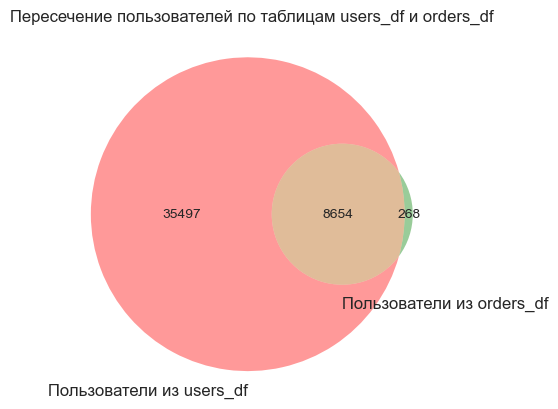

In [16]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_users = set(users_df['user_id'].unique())
users_orders = set(orders_df['user_id'].unique())
users_events = set(events_df['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_users, users_orders], set_labels = ['Пользователи из users_df', 'Пользователи из orders_df'])
plt.title("Пересечение пользователей по таблицам users_df и orders_df")
plt.show()

In [17]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_1 = users_orders & users_users
#Выведем пользователей, которые совершали заказ, но о них нет информации в таблице users_df
diff_users_1 = orders_df[~orders_df['user_id'].isin(intersection_1)]
diff_users_1_count = diff_users_1['user_id'].nunique()
print(f'Количество пользователей, которые не попали в таблицу users_df: {diff_users_1_count}') ### тут нашла, что их действительно 268
display(diff_users_1.head(5))

Количество пользователей, которые не попали в таблицу users_df: 268


,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
33,34,20,2024-01-05 03:55:21,Кардиган вязаный,2,9268.87,18537.74,Женская одежда,2024-01-01,2024-01-01
34,35,20,2024-01-05 03:55:21,Термос стальной,2,16469.18,32938.36,Товары для туризма,2024-01-01,2024-01-01
35,36,20,2024-01-05 03:55:21,Пальто зимнее,2,2401.55,4803.10,Женская одежда,2024-01-01,2024-01-01
36,37,20,2024-01-05 03:55:21,Спальный мешок,1,16542.45,16542.45,Товары для туризма,2024-01-01,2024-01-01
466,467,368,2024-01-24 05:25:26,Мука пшеничная,1,2179.75,2179.75,Продукты питания,2024-01-22,2024-01-01


In [18]:
#Выведем подобного пользователя из таблицы users_df для проверки
user_20 = users_df[users_df['user_id'] == 20]
display(user_20)

,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month


In [19]:
#Отфильтруем датафрейм orders_df по пользователям, которые имеются в пересечении таблиц orders_df и users_df
orders_df = orders_df[orders_df['user_id'].isin(intersection_1)]
print(orders_df['user_id'].nunique())

8654


В данных для анализа имеется неточность, т.к. пользователи, которые сделали заказ, по сути, должны быть в таблице с информацией о пользователях. Стоит для точности анализа отсутствующих пользователей исключить.


Посмотрим по идентификаторам, все ли пользователи, которые есть в таблице с заказами, есть в таблице с событиями пользователей:


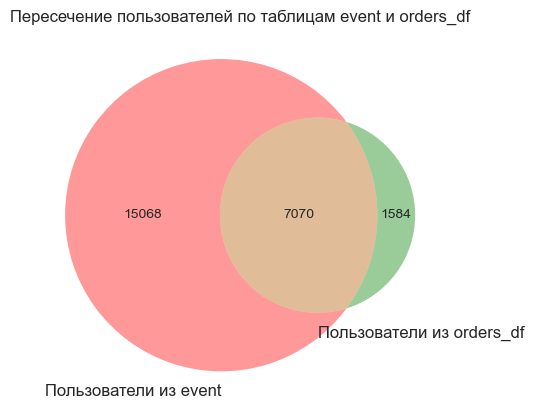

In [20]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_orders_1 = set(orders_df['user_id'].unique())
users_events = set(events_df['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_events, users_orders_1], set_labels = ['Пользователи из event', 'Пользователи из orders_df'])
plt.title("Пересечение пользователей по таблицам event и orders_df")
plt.show()

In [21]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_2 = users_orders_1 & users_events
#Выведем пользователей, которые совершали заказ, но о них нет информации в таблице events_df
diff_users_2 = orders_df[~orders_df['user_id'].isin(intersection_2)]
diff_users_2_count = diff_users_2['user_id'].nunique()
print(f'Количество пользователей, которые не попали в таблицу events_df: {diff_users_2_count}')
display(diff_users_2.head(5))

Количество пользователей, которые не попали в таблицу events_df: 1584


,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
32,33,15,2024-01-19 22:11:34,Помада матовая,1,7632.66,7632.66,Косметика и парфюмерия,2024-01-15,2024-01-01
44,45,24,2024-01-19 13:56:36,Свечи ароматические,2,9718.78,19437.56,Декор и освещение,2024-01-15,2024-01-01
78,79,49,2024-01-05 05:07:24,Кардиган вязаный,1,9268.87,9268.87,Женская одежда,2024-01-01,2024-01-01
81,82,64,2024-01-19 18:02:35,Лежак для питомца,1,3811.37,3811.37,Зоотовары,2024-01-15,2024-01-01
148,149,102,2024-01-07 14:39:02,Сахар белый,1,532.73,532.73,Продукты питания,2024-01-01,2024-01-01


In [22]:
#Выведем подобного пользователя из таблицы events_df для проверки
user_15 = events_df[events_df['user_id'] == 15]
display(user_15)

,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month


In [23]:
#Отфильтруем датафрейм orders_df по пользователям, которые имеются в пересечении таблиц orders_df и events_df
orders_df = orders_df[orders_df['user_id'].isin(intersection_2)]
print(orders_df['user_id'].nunique())

7070


В данных для анализа имеется неточность, т.к. пользователи, которые сделали заказ, должны быть отображены в событиях пользователя в таблице events_df. Для точного анализа, таких пользователей стоит исключить из дальнейшего анализа.


Посмотрим по идентификаторам, все ли пользователи, которые есть в таблице с заказами, есть в таблице с событиями пользователей:


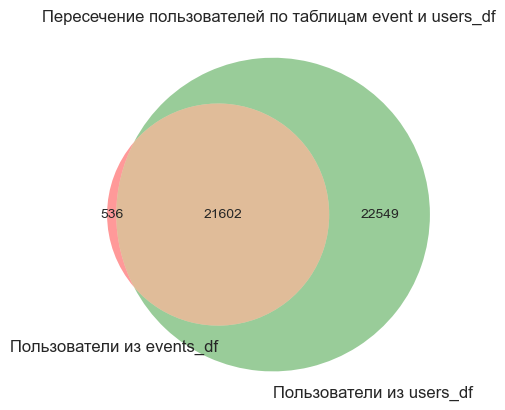

In [24]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_users_1 = set(users_df['user_id'].unique())
users_events_1 = set(events_df['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_events_1, users_users_1], set_labels = ['Пользователи из events_df', 'Пользователи из users_df'])
plt.title("Пересечение пользователей по таблицам event и users_df")
plt.show()

In [25]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_3 = users_users_1 & users_events_1
#Выведем пользователей, которые совершали какие-либо действия, но о них нет информации в таблице users_df
diff_users_3 = events_df[~events_df['user_id'].isin(intersection_3)]
diff_users_3_count = diff_users_3['user_id'].nunique()
print(f'Количество пользователей, которые не попали в таблицу events_df: {diff_users_3_count}')
display(diff_users_3.head(5))

Количество пользователей, которые не попали в таблицу events_df: 536


,event_id,user_id,event_date,event_type,os,device,product_name,event_week,event_month
359,2344,83,2024-01-04,page_view,Android,mobile,NaN,2024-01-01,2024-01-01
360,2345,83,2024-01-04,product_view,Android,mobile,Туфли на каблуке,2024-01-01,2024-01-01
361,2346,83,2024-01-04,banner_click,Android,mobile,NaN,2024-01-01,2024-01-01
415,524,17,2024-01-04,page_view,macOS,desktop,NaN,2024-01-01,2024-01-01
416,525,17,2024-01-04,product_view,macOS,desktop,Очки солнцезащитные,2024-01-01,2024-01-01


In [26]:
#Отфильтруем датафрейм events_df по пользователям, которые имеются в пересечении таблиц users_df и events_df
events_df = events_df[events_df['user_id'].isin(intersection_3)]
print(events_df['user_id'].nunique())

21602


В данных для анализа имеется неточность, т.к. пользователи, которые сделали какое-либо аналитическое действие, должны быть отображены в таблице с информацией о пользователях. Поэтому отсутствующих пользователей следует отфильтровать.

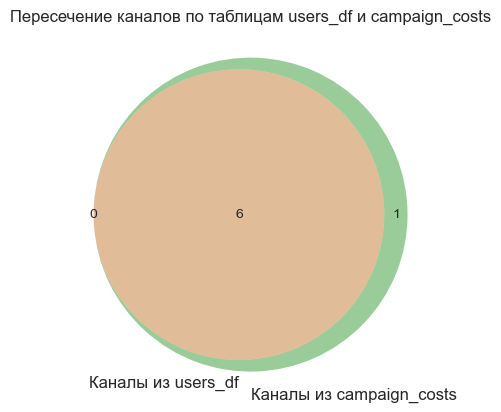

In [27]:
#Создадим множества для диаграммы Венна на основе названий каналов
channel_users = set(users_df['acq_channel'].unique())
channel_costs = set(campaign_costs['acq_channel'].unique())

#Строим диаграмму Венна для поиска пересечения каналов
venn2([channel_users, channel_costs], set_labels = ['Каналы из users_df', 'Каналы из campaign_costs'])
plt.title("Пересечение каналов по таблицам users_df и campaign_costs")
plt.show()

In [28]:
#Выведем каналы, которые имеются в двух датафреймах
intersection_4 = channel_users & channel_costs
#Выведем канал, который есть в затратах, но пользователей из этого канала нет (из users_df)
diff_channel = campaign_costs[~campaign_costs['acq_channel'].isin(intersection_4)]
diff_channel_count = diff_channel['acq_channel'].unique()
print(f'Канал, с которого нет пользователей в таблице users_df: {diff_channel_count}')
#Отфильтруем датафрейм campaign_costs по каналу, которого нет в users_df
campaign_costs = campaign_costs[campaign_costs['acq_channel'].isin(intersection_4)]
print(f"Каналы, которые есть в users_df и campaign_costs: {campaign_costs['acq_channel'].unique()}")

Канал, с которого нет пользователей в таблице users_df: ['Direct']
Каналы, которые есть в users_df и campaign_costs: ['Affiliate' 'Email Marketing' 'Social Media' 'Google Ads' 'SEO' 'TikTok']


В полученных данных нет информации о пользователях, которые пришли с канала `Direct`, поэтому его надо исключить из данных для последующей работы.

Также сразу добавим в датафрейм с информацией о пользователях стоимость привлечения каждого (столбец `cac`):

In [29]:
#Сгруппируем пользователей по когорте и каналу привлечения
users_cac = users_df.groupby(['acq_channel', 'cohort_month'])['user_id'].nunique().reset_index()

#Присоединим к полученному датафрейму бюджеты каналов
users_cac = pd.merge(users_cac, campaign_costs, left_on=['acq_channel', 'cohort_month'], right_on=['acq_channel','spend_month'])

#Рассчитаем стоимость привлечения каждого пользователя по каналу
users_cac['cac'] = (users_cac['budget'] / users_cac['user_id']).round(2)

#Присоединим полученную стоимость привлечения по когорте и каналу каждому пользователю
users_df= pd.merge(users_df, users_cac[['acq_channel', 'cohort_month', 'cac']], on=['acq_channel', 'cohort_month'])
users_df.head()

,user_id,registration_date,age,gender,region,acq_channel,buyer_segment,cohort_week,cohort_month,cac
0,1,2024-01-01 00:47:00,35,M,Москва,Google Ads,regular,2024-01-01,2024-01-01,500.34
1,2,2024-01-01 19:01:00,53,M,Москва,Email Marketing,rare,2024-01-01,2024-01-01,252.93
2,3,2024-01-01 04:13:00,66,F,Санкт-Петербург,Google Ads,regular,2024-01-01,2024-01-01,500.34
3,4,2024-01-01 17:18:00,58,M,Краснодар,Affiliate,one_time,2024-01-01,2024-01-01,311.90
4,5,2024-01-01 08:29:00,58,F,Другие регионы,Google Ads,regular,2024-01-01,2024-01-01,500.34


### Промежуточный вывод по предобработке данных
- в датафрейме `users_df` нет пропусков и дубликатов, категориальные данные изучены. Также была рассчитана стоимость привлечения каждого пользователя и добавлена в датафрейм.
- в датафрейме `orders_df` нет пропусков и дубликатов, категориальные данные по столбцам изучены. Также было найдено **268 пользователей** с заказами, user_id которых не было в таблице с информацией о пользователях `users_df` и **1584 пользователя** с заказами, для которых не было событий (логов) с user_id в таблице events_df. Такие пользователи были удалены чтобы не искажать результаты аналитического исследования.
- в датафрейме `events_df` есть пропуски в столбце `product_name`. Их никак не заполнить по причине того, что если событие не связано с товаром (например, вход в аккаунт) - название товаров не будет отображаться. Дубликатов нет, было удалено **536 пользователей**, так как о них не нашлось информации по user_id в таблице `users_df`, следственно эти пользователи не должны учитываться при дальнейшем анализе.
- в датафрейме `campaign_costs` пропусков и дубликатов не обнаружено. Был удален столбец Unnamed, который дублировал индексы строк, а также информация по январю 2025 года. Так же в этом датафрейме числился канал `Direct`, пользователей с которого не было найдено в `users_df`, поэтому этот канал был исключен для дальнейшего анализа.
-----

## 2. Обзор ключевых метрик

Необходимо выполнить верхнеуровневую оценку состояния продукта. Бизнес просит просто оценить текущее состояние — без глубокой сегментации и оценки сложных метрик.

Выручка бизнеса — 5% комиссии от стоимости любой продажи.

### Ключевые показатели для анализа

1. <u>Ключевые метрики</u>

   1.1. *Динамика продаж*
    > Выручка\
    > Количество заказов\
    > Средний чек

   1.2. *Привлечение пользователей*
    > Новые пользователи

   1.3. *Вовлеченность пользователей*
    > DAU и MAU (уникальные пользователи, которые взаимодействовали с продуктом за день и за месяц)\
    > Retention Rate (коэффициент удержания, который показывает, сколько пользователей продолжают пользоваться приложением в течение определенного промежутка времени)\
    > Conversation Rate (процент пользователей, совершивших целевое действие из общего числа пользователей)


2. <u>Метрики монетизации</u>

   2.1. *Доходность*
    > Доход маркетплейса\
    > ARPU (средний доход с активного пользователя)\
    > ARPPU (средний доход с активного платящего пользователя)

   2.2. *Окупаемость инвестиций*
    > LTV (суммарная прибыль от одного пользователя за весь период взаимодействия)\
    > CAC (стоимость привлечения одного пользователя)\
    > ROI (показатель рентабельности инвестиций)\
    > Payback Period (период окупаемости инвестиций)




Для начала начнем с самой главной ключевой метрики - выручки маркетплейса (GMV), т.е. сколько пользователь принес денег бизнесу:


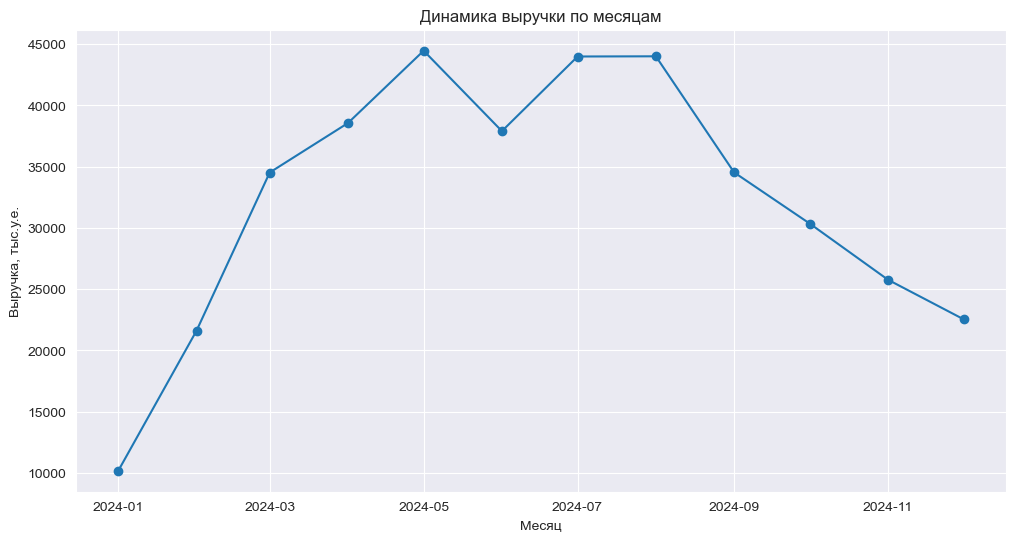

In [30]:
gmv = orders_df.groupby('order_month')['total_price'].sum().reset_index().rename(columns={'total_price':'gmv'})

#Cтроим график
plt.figure(figsize=(12, 6))
plt.plot(gmv['order_month'], gmv['gmv']/1000, marker='o')
plt.xlabel('Месяц')
plt.ylabel('Выручка, тыс.у.е.')
plt.title('Динамика выручки по месяцам')
plt.show()

Динамика выручки маркетплейса по месяцам нестабильная - возможно присутствует сезонность. Начиная с апреля вырчука идет вверх, в июне заметнен некоторый спад и несколько месяцев (июль и август) вырчука находится на одном уровне. После чего с сентября по декабрь идет резкий спад.





Теперь посмотрим на общее количество заказов в маркетплейсе:

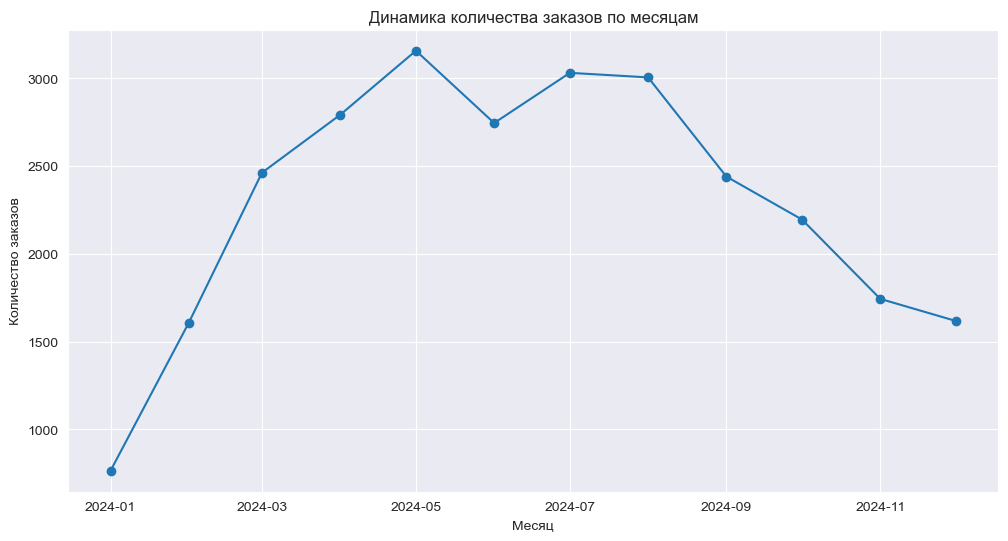

In [31]:
order_count = orders_df.groupby('order_month')['order_id'].nunique().reset_index().rename(columns={'order_id':'order_count'})
#Cтроим график
plt.figure(figsize=(12, 6))
plt.plot(order_count['order_month'], order_count['order_count'], marker='o')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.title('Динамика количества заказов по месяцам')
plt.show()

В динамике количества заказов по месяцам также прослеживается сезонность - с марта количество заказов увеличилось до 2500, с мая по август было в диапазоне 2750-3200, и с сентября по декабрь падало - с 2400 до 1600.

Посмотрим на помесячную динамику среднего чека (AOV) исходя из total_price:

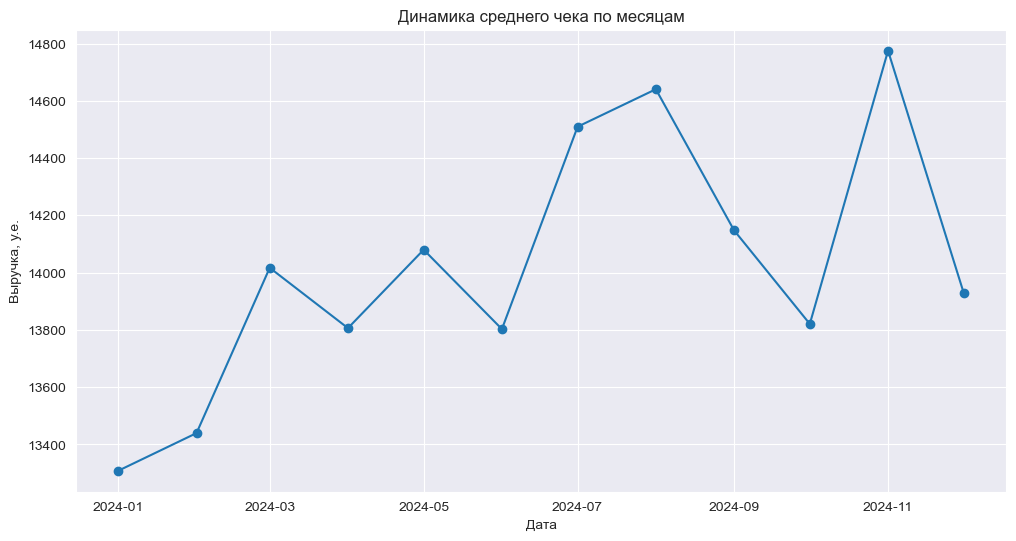

In [32]:
aov = orders_df.groupby('order_month').agg(
    total_revenue = ('total_price', 'sum'),
    count_order = ('order_id', 'count')
).reset_index()
aov['aov'] = aov['total_revenue'] / aov['count_order']
#Cтроим график
plt.figure(figsize=(12, 6))
plt.plot(aov['order_month'], aov['aov'], marker='o')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.title('Динамика среднего чека по месяцам')
plt.show()

Исходя из динамики среднего чека по месяцам, можно сказать, что в первом полугодии был устойчивый рост среднего чека (с 13300 до 13800 у.е.), летние месяцы били рекорды по среднему чеку, что может говорить о явной сезонности товаров, представленных на маркетплейсе (диапазон 14100-14600). Затем средний чек падает до значений начала года, исключением является ноябрь (в этом месяце обычно проводят распродажи, к примеру, всемирно известная 'Black Friday') - средний чек составил 14700 у.е.

Посмотрим количество новых пользователей на маркетплейсе в динамике:


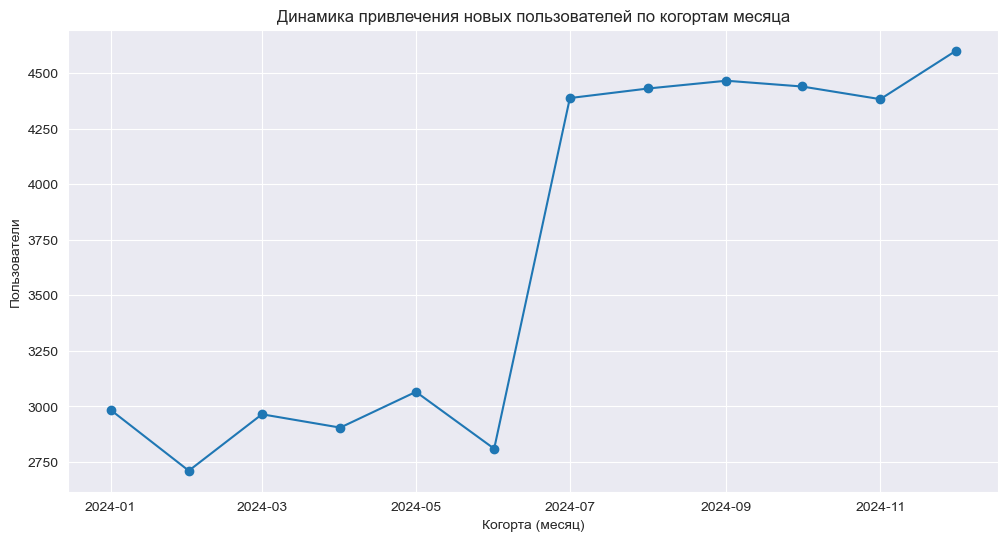

In [33]:
new_users = users_df.groupby('cohort_month')['user_id'].nunique().reset_index()

#Строим график
plt.subplots(figsize=(12,6))
plt.plot(new_users['cohort_month'], new_users['user_id'], marker='o')
plt.title('Динамика привлечения новых пользователей по когортам месяца')
plt.ylabel('Пользователи')
plt.xlabel('Когорта (месяц)')
plt.grid(True)
plt.show()

По динамике привлечения новых пользователей на сайт маркетплейса заметно, что с января по июнь привлекалось стабильное количество(2700-3000). С июля по декабрь на маркетплейс начало приходить в 1,5 раза больше новых пользователей (4300-4600).

Построим метрику DAU, MAU для пользователей маркетплейса для оценки их активности:

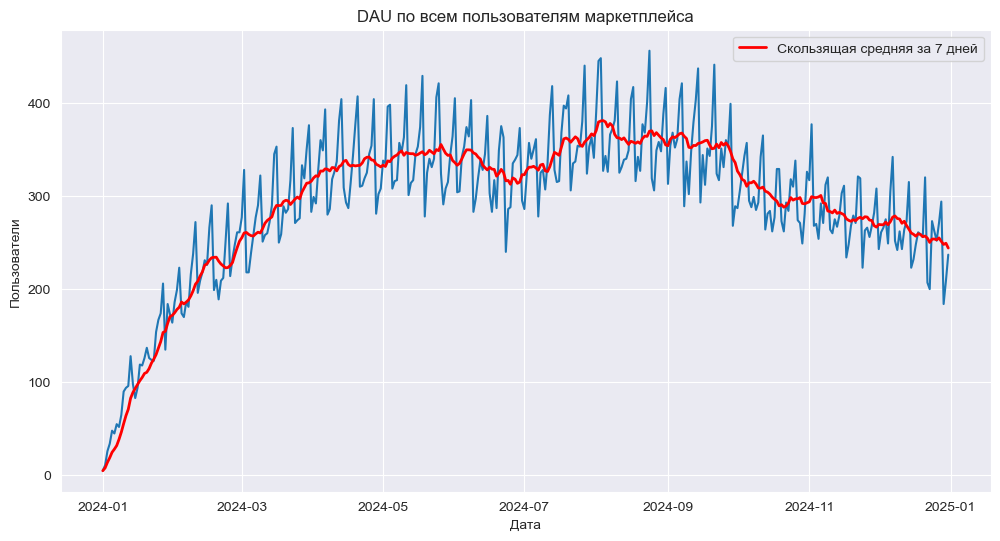

In [34]:
#Рассчитаем количество уникальных пользователей в день
dau = events_df.groupby('event_date')['user_id'].nunique().reset_index()

#Строим график
plt.subplots(figsize=(12,6))
plt.plot(dau['event_date'], dau['user_id'])

#Рассчитаем скользящую среднюю за 7 дней для сглаживания графика
dau_users_mean = dau['user_id'].rolling(window=7, min_periods=1).mean()

#Добавим скользящую среднюю на график
plt.plot(dau['event_date'], dau_users_mean, label='Скользящая средняя за 7 дней', linewidth=2, color='red')

plt.title('DAU по всем пользователям маркетплейса')
plt.ylabel('Пользователи')
plt.xlabel('Дата')
plt.grid(True)
plt.legend()
plt.show()

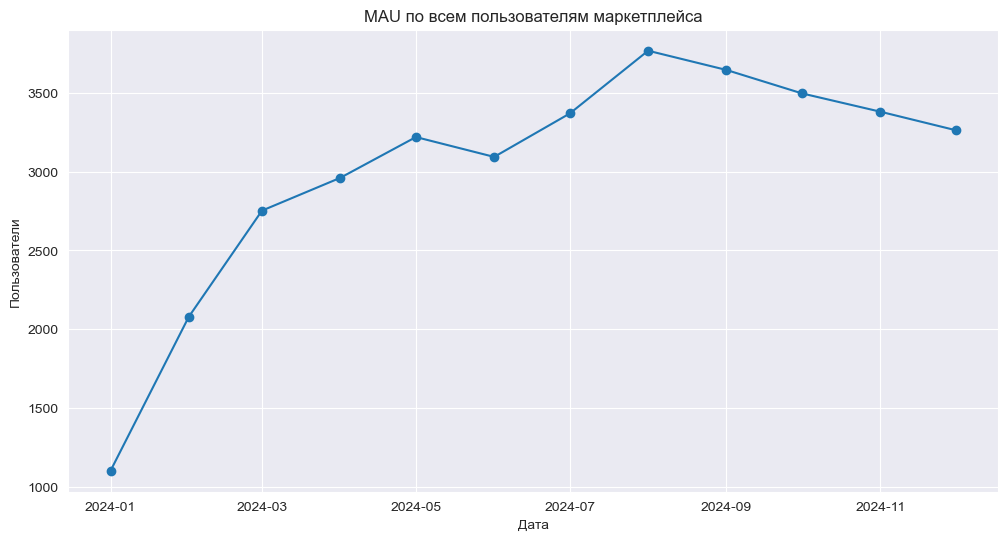

In [35]:
#Рассчитаем количество уникальных пользователей в месяц
mau = events_df.groupby('event_month')['user_id'].nunique().reset_index()

#Строим график
plt.subplots(figsize=(12,6))
plt.plot(mau['event_month'], mau['user_id'], marker='o')
plt.title('MAU по всем пользователям маркетплейса')
plt.ylabel('Пользователи')
plt.xlabel('Дата')
plt.grid(True)
plt.show()

По графику уникальных посетителей в день (DAU), можно увидеть некоторую сезонность - с марта по июнь количество уникальных пользователей росло (примерно с 250 до 340), летом уровень пользователей примерно на одном уровне(320-380), после чего в сентябре до декабря шло плавное снижение числа уникальных пользователей (с 350 до 250).

При этом из графика уникальных посетителей в месяц(MAU) можно увидеть, что количество пользователей, посещавших маркетплейс, с начала года растет до августа (с 1100 до 3700), после чего с сентября заметно значительное снижение посещений(с 3600 до 3200).

Также можем посмотреть, как часто пользователи (в разрезе месячной когорты) возвращаются повторно на сайт маркетплейса в течение 30 дней:


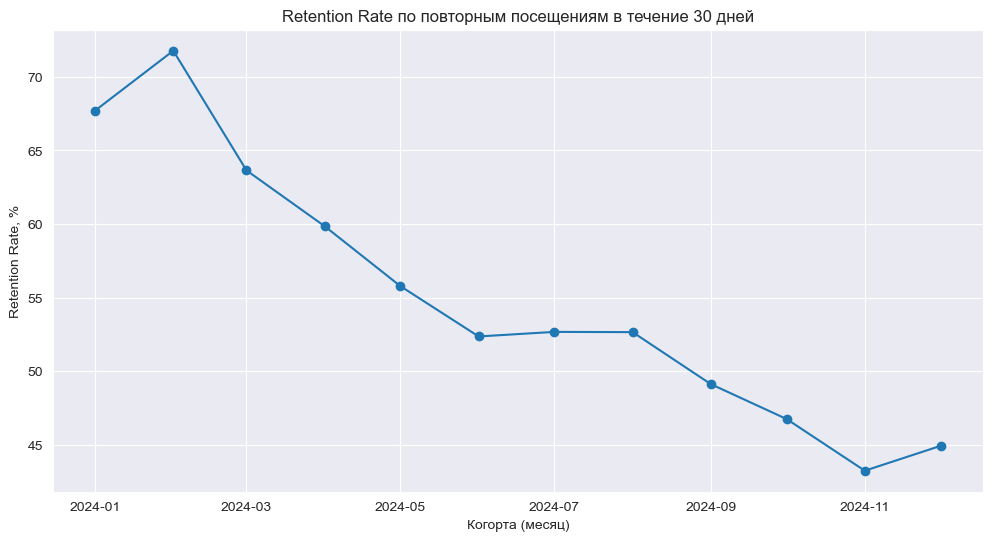

In [36]:
#Узнаем дату первого посещения
events_df_1 = events_df.copy()
events_df_1['first_event_date'] = events_df_1.groupby('user_id')['event_date'].transform('min')

#Вычислим, сколько дней прошло с первого посещения
events_df_1['lifetime'] = (events_df_1['event_date'] - events_df_1['first_event_date']).dt.days
events_df_1['first_event_date'] = events_df_1['first_event_date'].dt.to_period('M').dt.to_timestamp()

#Считаем, сколько пользователей заходили на сайт маркетплейса
rr_all_users_event = events_df_1.groupby('event_month')['user_id'].nunique().reset_index().rename(columns={'user_id': 'rr_all_users_event', 'event_month':'month_cohort'})
#Считаем, сколько пользователей повторно зашли на сайт маркетплейса в течение 30 дней после первого посещения
rr_users_30_days_event_1 = events_df_1[(events_df_1['lifetime'] > 0) & (events_df_1['lifetime'] <= 30)].copy()
rr_users_30_days_event = rr_users_30_days_event_1.groupby('event_month')['user_id'].nunique().reset_index().rename(columns={'user_id': 'rr_users_30_days_event', 'event_month':'month_cohort'})

#Объединяем пользователей в общий датасет
rr_event = pd.merge(rr_all_users_event, rr_users_30_days_event, on='month_cohort', how='left')

#Считаем Retention rate в повторное посещение
rr_event['Retention_rate'] = (rr_event['rr_users_30_days_event'] / rr_event['rr_all_users_event']) * 100

#Строим график
plt.figure(figsize=(12, 6))
plt.plot(rr_event['month_cohort'], rr_event['Retention_rate'], marker='o')
plt.xlabel('Когорта (месяц)')
plt.ylabel('Retention Rate, %')
plt.title('Retention Rate по повторным посещениям в течение 30 дней')
plt.show()

В метрике Retention Rate для повторных посещений в течение 30 дней заметен тренд на снижение возвращаемости пользователей - с февраля метрика начала падать c 71% до 52% в июне, летом была стагнация в районе 52%, с сентября по декабрь когорты метрика была в районе 43-49%.

Посмотрим, как пользователь проходит путь от появления в приложении до покупки, и на каких стадиях больше всего падает конверсия:

In [37]:
#Зададим порядок шагов в воронке
funnel_step = ['page_view', 'product_view', 'product_click', 'add_to_cart', 'checkout_start',  'checkout_complete']

#Считаем число новых уникальных пользователей на каждом шаге
funnel_count_event = events_df.groupby(['event_type'])['user_id'].nunique().reindex(funnel_step)

#Соберем таблицу воронки
funnel_event = pd.DataFrame({
   'step': funnel_step,
   'count_users': funnel_count_event.values
})

#Добавим конверсии и округляем до 1 знака после запятой
funnel_event['conversion_from_first_%'] = (funnel_event['count_users'] / funnel_event['count_users'].iloc[0] * 100).round(1)
funnel_event['conversion_from_previous_%'] = (funnel_event['count_users'] / funnel_event['count_users'].shift(1) * 100).round(1)
funnel_event.head(6)

,step,count_users,conversion_from_first_%,conversion_from_previous_%
0,page_view,21562,100.0,NaN
1,product_view,21533,99.9,99.9
2,product_click,21211,98.4,98.5
3,add_to_cart,19887,92.2,93.8
4,checkout_start,16293,75.6,81.9
5,checkout_complete,13486,62.5,82.8


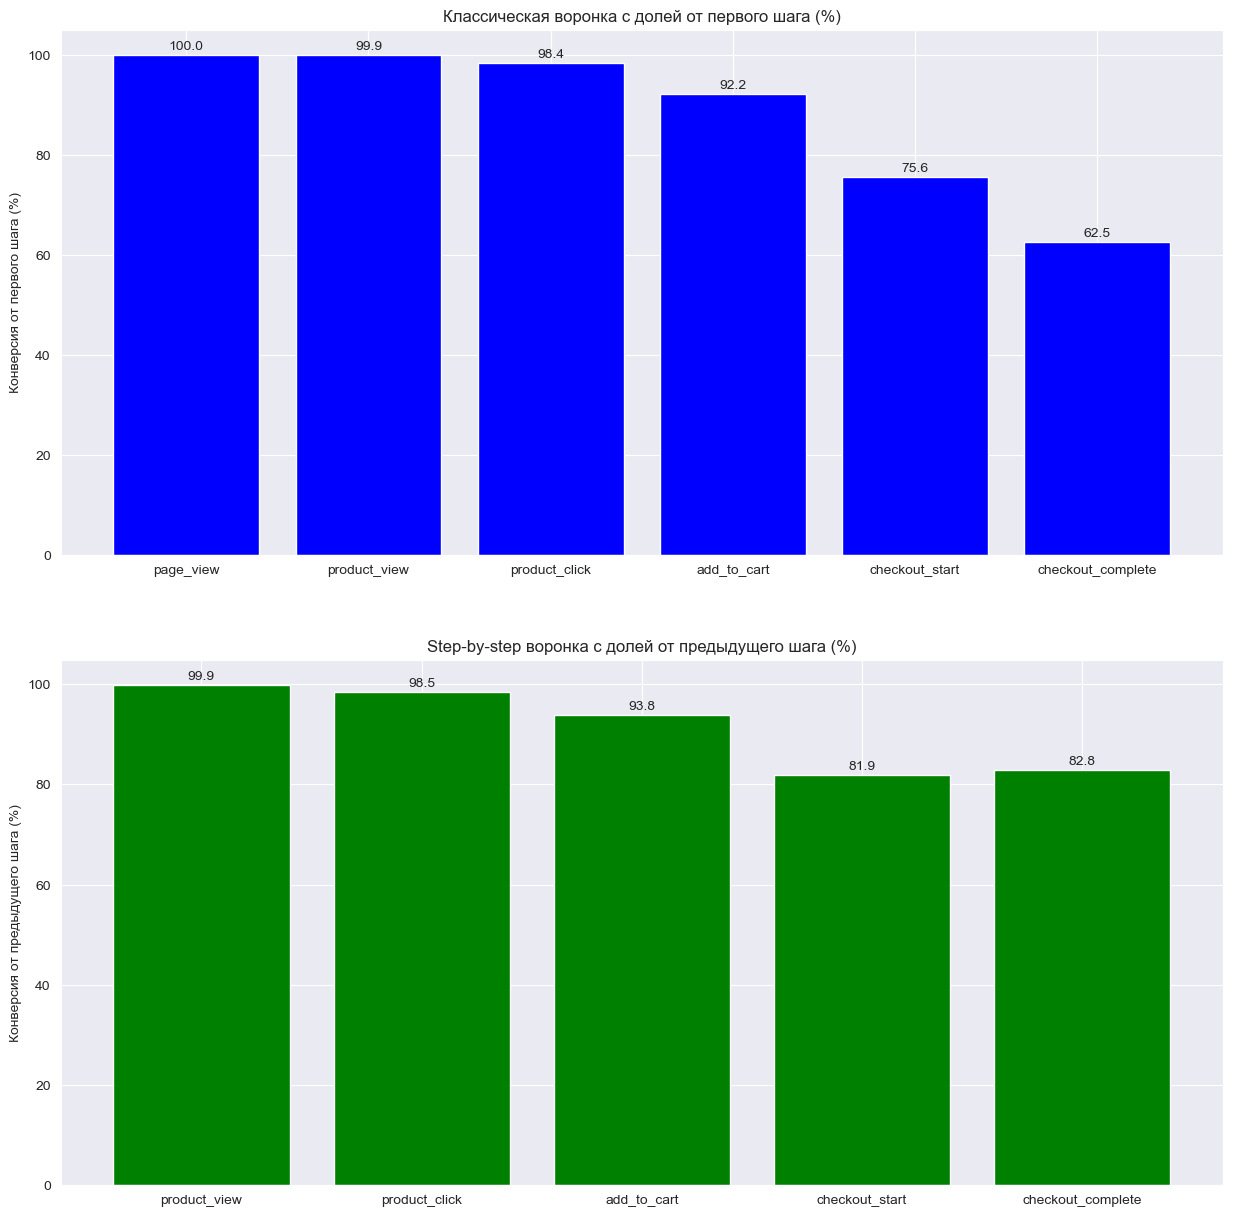

In [38]:
#Строим графики
fig, axes = plt.subplots(2, 1, figsize=(15, 15))
#Визуализируем классическую воронку
bars_1 = axes[0].bar(funnel_event['step'], funnel_event['conversion_from_first_%'], color='blue')
axes[0].set_title('Классическая воронка с долей от первого шага (%)')
axes[0].set_ylabel('Конверсия от первого шага (%)')
#Добавление подписей
for bar, value in zip(bars_1, funnel_event['conversion_from_first_%']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom')

#Визуализируем воронку step-by-step, исключая первый шаг
bars_2 = axes[1].bar(funnel_event['step'][1:], funnel_event['conversion_from_previous_%'][1:], color='green')
axes[1].set_title('Step-by-step воронка с долей от предыдущего шага (%)')
axes[1].set_ylabel('Конверсия от предыдущего шага (%)')
#Добавление подписей для второго графика
for bar, value in zip(bars_2, funnel_event['conversion_from_previous_%'][1:]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{value:.1f}', ha='center', va='bottom')

plt.show()

Самое узкое место в пути пользователя от просмотра товара до завершения оформления является начало оформления (шаг `chekout_start`) - 81.9% от предыдущего шага, а затем завершение оформления заказа (шаг `chekout_complete`) - 82.8% от предыдущего шага.

Посмотрим на динамику конверсии из шага `add_to_cart` в оформление заказа `checkout_start` по месяцам:


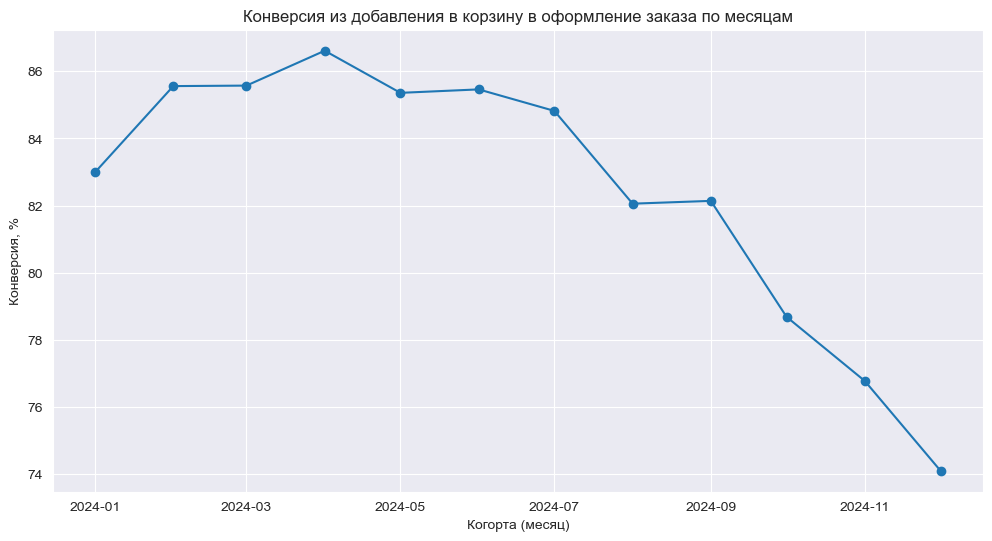

In [39]:
#Отфильтруем нужные шаги
funnel = events_df[events_df['event_type'].isin(['checkout_start', 'add_to_cart'])]
#Считаем уникальных пользователей на стадии добавления в корзину и оформления заказа
cr_start = funnel[funnel['event_type']=='add_to_cart'].groupby('event_month')['user_id'].nunique().reset_index() .rename(columns={'user_id': 'add_to_cart_users', 'event_month':'month_cohort'})

cr_complete = funnel[funnel['event_type']=='checkout_start'].groupby('event_month')['user_id'].nunique().reset_index().rename(columns={'user_id': 'checkout_start_users', 'event_month':'month_cohort'})

#Соединим два датасета с кол-вом пользователей на стадии добавления в корзину и на оформлении заказа
cr_1 = pd.merge(cr_start, cr_complete, how='left', on='month_cohort')

#Посчитаем метрику Conversion Rate
cr_1['conversion_from_first_%'] = (cr_1['checkout_start_users']/cr_1['add_to_cart_users']) * 100

#Строим график
plt.figure(figsize=(12, 6))
plt.plot(cr_1['month_cohort'], cr_1['conversion_from_first_%'], marker='o')
plt.xlabel('Когорта (месяц)')
plt.ylabel('Конверсия, %')
plt.title('Конверсия из добавления в корзину в оформление заказа по месяцам')
plt.show()

Заметно, что конверсия из добавления в корзину (`add_to_cart`) в начало оформления заказа (`checkout_start`) начала падать для когорт после июля (85%) и в декабре достигла 74%.



## 3. Оценка метрик монетизации и юнит-экономики

Необходимо выполнить анализ монетизации, определить, сколько зарабатывает продукт и сколько тратит на привлечение. Выводы по 2 и 3 блоку оформить в формате записки для заказчика.

Посчитаем доход маркетплейса (комиссия 5% с каждого заказа) за вычетом затрат на привлечение пользователей:

,order_month,total_price,spend_month,budget,revenue
0,2024-01-01,10180755.07,2024-01-01,1.165566e+06,-6.565284e+05
1,2024-02-01,21610843.08,2024-02-01,1.051718e+06,2.882460e+04
2,2024-03-01,34523375.55,2024-03-01,1.158740e+06,5.674286e+05
3,2024-04-01,38560569.35,2024-04-01,1.137992e+06,7.900362e+05
4,2024-05-01,44464554.59,2024-05-01,1.217614e+06,1.005614e+06


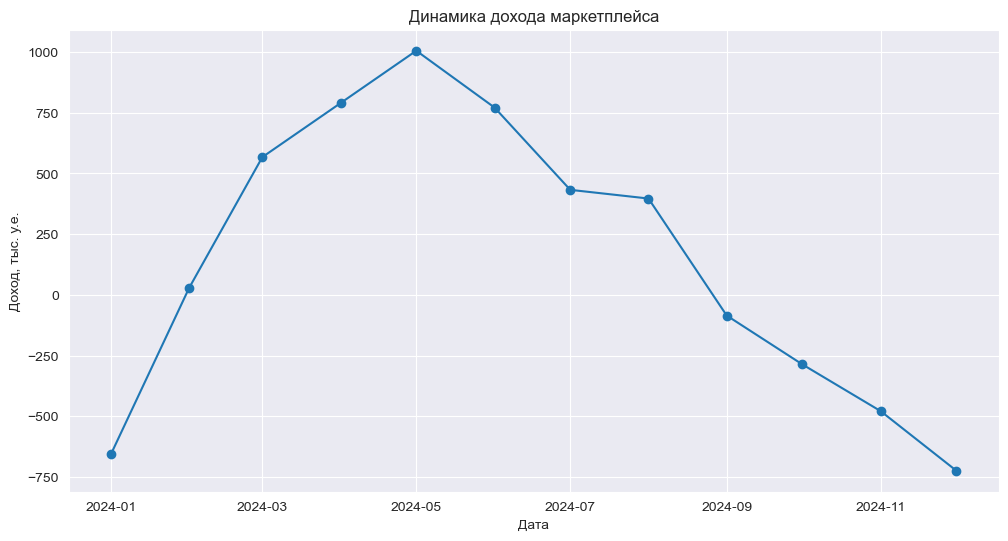

In [40]:
revenue = orders_df.groupby('order_month')['total_price'].sum().reset_index()
costs = campaign_costs.groupby('spend_month')['budget'].sum().reset_index()
revenue = pd.merge(revenue, costs, left_on = 'order_month', right_on = 'spend_month')
revenue['revenue'] = (revenue['total_price'] *0.05) - revenue['budget']
display(revenue.head(5))

#Cтроим график
plt.figure(figsize=(12, 6))
plt.plot(revenue['order_month'], revenue['revenue']/1000, marker='o')
plt.xlabel('Дата')
plt.ylabel('Доход, тыс. у.е.')
plt.title('Динамика дохода маркетплейса')
plt.show()

В динамике дохода маркетплейса также не все стабильно: доход из отрицательных значений вышел на положительные только с марта месяца вплоть до августа. С сентября до декабря маркетплейс не получал доход от продаж, учитывая маркетинговые вложения.

Теперь посмотрим, сколько денег приносит один пользователь, который хоть раз посещал маркетплейс, в месяц (ARPU) (исходя из комиссии):


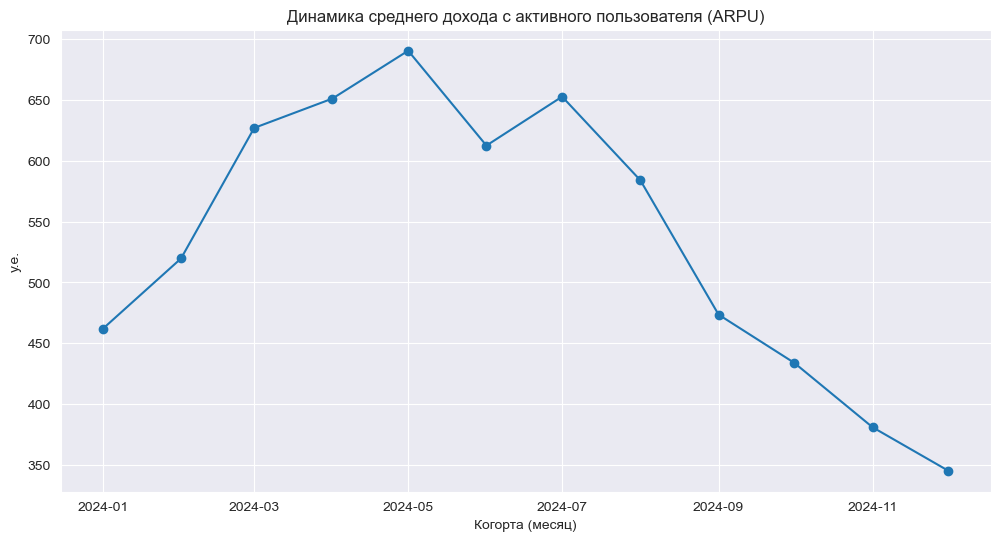

In [41]:
#Считаем пользователей, которые хоть раз заходили на сайт маркетплейса за месяц(активный пользователь)
active_users = events_df.groupby('event_month')['user_id'].nunique().reset_index().rename(columns={'event_month':'month_cohort'})

#Посчитаем доход (комиссия) с заказов за месяцам
total_revenue_orders = orders_df.copy()
total_revenue_orders['comission'] = total_revenue_orders['total_price'] * 0.05
total_revenue_orders = total_revenue_orders.groupby('order_month')['comission'].sum().reset_index()

#Объединим пользователей с доходом от них по месяцам
arpu = pd.merge(active_users, total_revenue_orders, left_on = 'month_cohort', right_on = 'order_month')

#Посчитаем метрику среднего дохода с активного пользователя
arpu['arpu'] = arpu['comission'] / arpu['user_id']

#Cтроим график
plt.figure(figsize=(12, 6))
plt.plot(arpu['month_cohort'], arpu['arpu'], marker='o')
plt.xlabel('Когорта (месяц)')
plt.ylabel('у.е.')
plt.title('Динамика среднего дохода c активного пользователя (ARPU)')
plt.show()

Исходя из графика динамики среднего дохода с активного пользователя заметно, что с января по июль средний доход рос (c 460 у.е. до 650 у.е.) после чего доход начал снижаться с августа по декабрь (с 580 у.е. до 340 у.е.).

Посмотрим динамику среднего дохода с платящего пользователя (по комиссии):

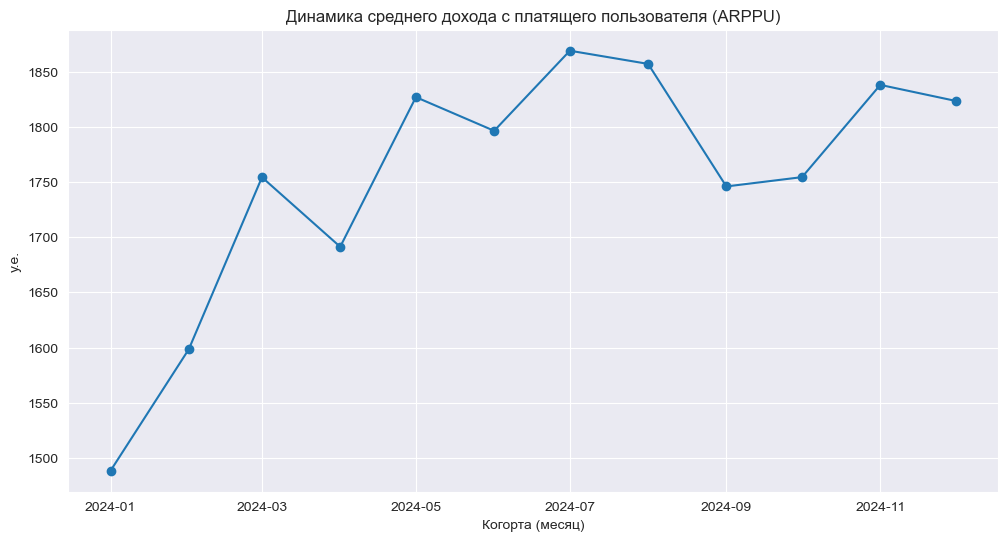

In [42]:
#Считаем пользователей, которые хоть раз делали заказ (платящие пользователи)
buyer_users = orders_df.groupby('order_month')['user_id'].nunique().reset_index().rename(columns={'order_month':'month_cohort'})

#Размер дохода от комиссии рассчитывали в apru в переменной total_revenue_orders
#Соединим платящих пользователей с доходом от комиссии по месяцам
arppu = pd.merge(buyer_users, total_revenue_orders, left_on='month_cohort', right_on='order_month')

#Посчитаем метрику среднего дохода с платящего пользователя
arppu['arppu'] = arppu['comission'] / arppu['user_id']

#Строим график
plt.figure(figsize=(12, 6))
plt.plot(arppu['month_cohort'], arppu['arppu'], marker='o')
plt.xlabel('Когорта (месяц)')
plt.ylabel('у.е.')
plt.title('Динамика среднего дохода с платящего пользователя (ARPPU)')
plt.show()


В динамике среднего дохода с платящего пользователя также наблюдается небольшой спад после летних месяцев. Если с когорты января по когорту августа средний доход вырос с 1490 у.е. до 1860 у.е., то с сентября по декабрь этот показатель был в диапазоне 1740 - 1830 у.е.

Посчитаем доход от пользователей за всё время сотрудничества (LTV):

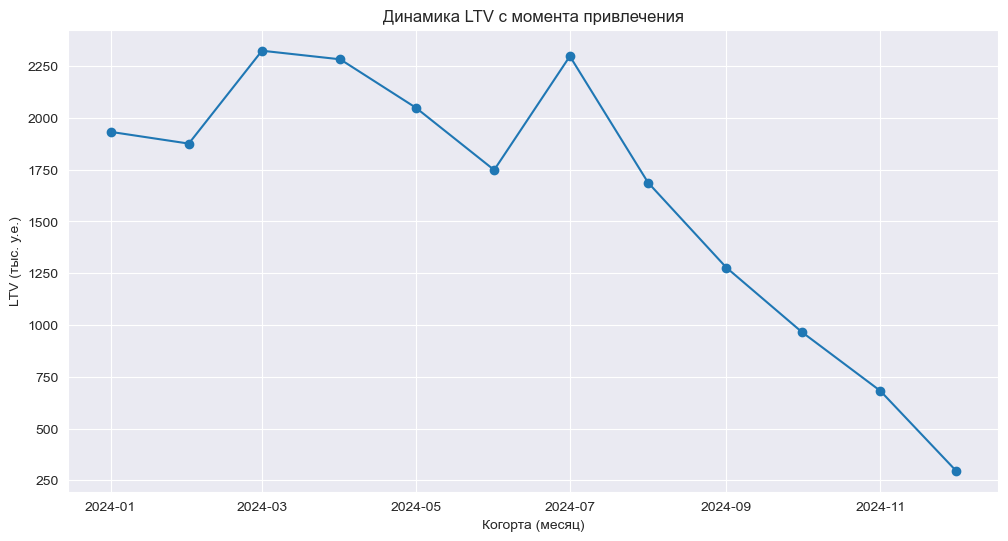

In [43]:
#Выделим для расчета LTV необходимые колонки
ltv = orders_df[['order_id', 'user_id', 'order_date', 'total_price', 'order_month']].copy()

#Присоединим дату регистрации пользователей, которую будем считать за первое взаимодействие с маркетплейсом
ltv = pd.merge(orders_df[['order_id', 'user_id', 'order_date', 'total_price', 'order_month']], users_df[['user_id', 'registration_date', 'cohort_month', 'acq_channel']], on = 'user_id', how='right' )

#Переименуем дату регистрации в дату первого взаимодействия с маркетплейсом
ltv.rename(columns={'registration_date': 'first_date'}, inplace=True)

#Рассчитаем время взаимодействия пользователя (от регистрации) до следующего события
ltv['lifetime'] = (ltv['order_date'] - ltv['first_date']).dt.days

#Посчитаем размер дохода от комиссии
ltv['comission'] = ltv['total_price'] * 0.05

# Сортируем значения для корректного расчёта кумулятивной суммы
ltv.sort_values(by=['first_date', 'lifetime'])

#Преобразуем даты датафрейма к формату `yyyy-mm-dd`
ltv['first_date'] = pd.to_datetime(ltv['first_date']).dt.to_period('M').dt.to_timestamp()

#Для каждой когорты рассчитываем сумму дохода с пользователя - LTV
ltv_sum = ltv.groupby(['cohort_month'])['comission'].sum().reset_index().rename(columns={'comission':'ltv'})

#Строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(ltv_sum['cohort_month'], ltv_sum['ltv']/1000, marker='o')
plt.xlabel('Когорта (месяц)')
plt.ylabel('LTV (тыс. у.е.)')
plt.title('Динамика LTV с момента привлечения')
plt.show()

Исходя из графика динамики LTV с момента привлечения становится заметно, что пользователи когорт после августа меньше стали покупать на маркетплейсе, о чем свидетельствует снижение LTV.

Посчитаем среднюю стоимость привлечения пользователя по месяцам:

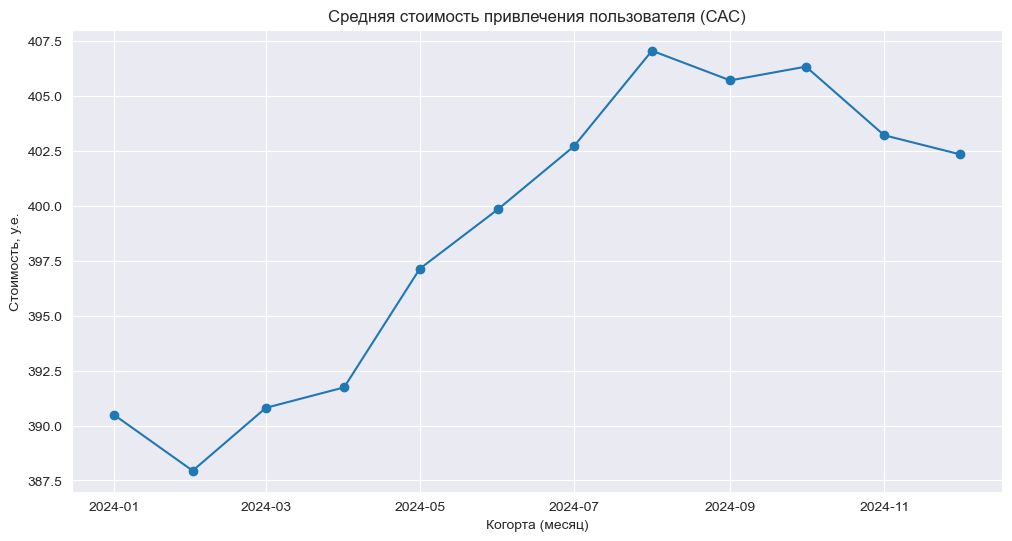

In [44]:
#Считаем среднюю стоимость привлечения пользователя в разрезе месяца
cac_avg = users_df.groupby('cohort_month')['cac'].mean().reset_index()

#Строим график
plt.subplots(figsize=(12,6))
plt.plot(cac_avg['cohort_month'], cac_avg['cac'], marker='o')
plt.title('Средняя стоимость привлечения пользователя (САС)')
plt.xlabel('Когорта (месяц)')
plt.ylabel('Стоимость, у.е.')
plt.grid(True)
plt.show()

График средней стоимости привлечения пользователя (САС) показывает, что с марта по август стоимость повышалась с 390 у.е. до 407 у.е. на пользователя, после чего с сентября по декабрь стоимость привлечения была примерно на том уже уровне (402-406 у.е.)

Посмотрим на динамику окупаемости вложений (ROI) на пользователей когорт по месяцам:

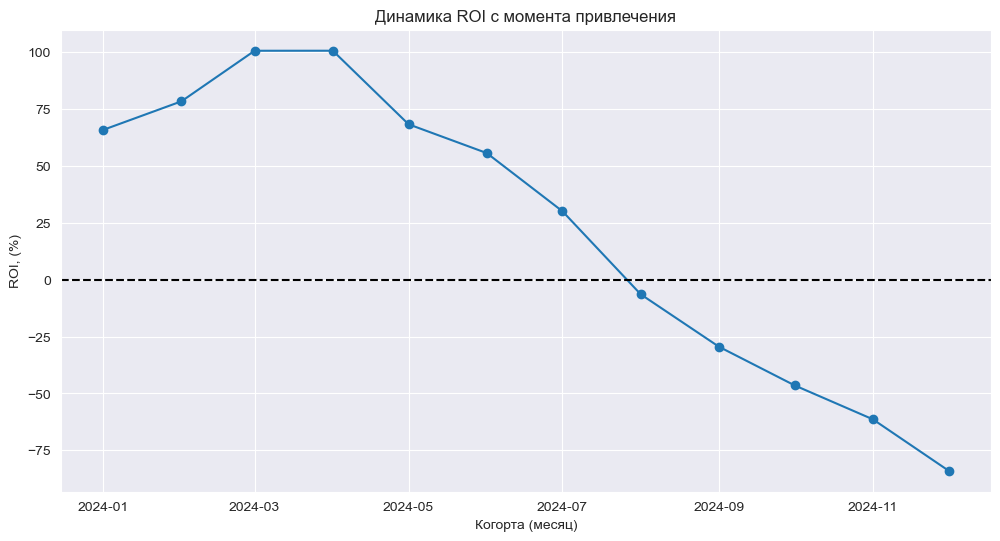

In [45]:
#Рассчитываем CAC на каждый месяц
cac_month = users_df.groupby(['cohort_month'])['cac'].agg(cac = 'sum').reset_index()

#Создаем новый датафрейм на основе ltv_sum и cac_month
roi = pd.merge(ltv_sum, cac_month, on='cohort_month')

#Посчитаем ROI
roi['ROI'] = (roi['ltv']-roi['cac'])/roi['cac'] *100

#Строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(roi['cohort_month'], roi['ROI'], marker='o')
#Добавим горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.xlabel('Когорта (месяц)')
plt.ylabel('ROI, (%)')
plt.title('Динамика ROI с момента привлечения')
plt.show()

Заметно, что окупаемости вложений (ROI) достигли не все когорты. Если когорты первого полугодия показывают хорошие результаты, то когорты с начала августа перестали окупаться.

Теперь рассчитаем срок окупаемости вложений в каждую когорту:

In [46]:
#Рассчитаем сумму дохода(комиссии) на каждую когорту месяца по всем месяцам (order_month)
ltv_month = ltv.groupby(['cohort_month', 'order_month'])['comission'].sum().reset_index().rename(columns={'comission':'ltv'})

#Рассчитаем кумулятивную сумму дохода
ltv_month['ltv_cumulative'] = ltv_month.groupby(['cohort_month'])['ltv'].cumsum()

#Соединим ltv_month с бюджетами на рекламу costs и удалим лишнюю колонку spend_month
payback = pd.merge(ltv_month, costs, left_on='cohort_month', right_on='spend_month').rename(columns={'budget':'cac_month'})
payback.drop(columns='spend_month', inplace=True)

#Рассчитаем сколько чистого дохода остается каждый месяц
payback['cash_flow'] = payback['ltv_cumulative'] - payback['cac_month']

payback['day_number'] = (payback['order_month'] - payback['cohort_month'])

#Функция для определения месяца окупаемости
def find_payback_period(group):
    #Находим первый месяц, где окупаемость >= 0
    positive_months = group[group['cash_flow'] >= 0]
    if not positive_months.empty:
        payback_period_days = positive_months['day_number'].iloc[0]
        return payback_period_days
    else:
        return None  #Если когорта еще не окупилась

#Применим функцию к каждой когорте
payback_results = payback.groupby('cohort_month').apply(find_payback_period)
payback_results.name = 'payback_period_days'

#Отобразим результаты срока окупаемости для когорт
payback_results.reset_index()

,cohort_month,payback_period_days
0,2024-01-01,60 days
1,2024-02-01,29 days
2,2024-03-01,31 days
3,2024-04-01,30 days
4,2024-05-01,31 days
5,2024-06-01,30 days
6,2024-07-01,62 days
7,2024-08-01,NaT
8,2024-09-01,NaT
9,2024-10-01,NaT


Сроки окупаемости (Payback Period) показывают, что когорты с февраля по июнь окупались достаточно быстро (30-31 день), с когортой июля все уже сложнее - она окупилась за 62 дня. Вложения для пользователей когорт с августа по декабрь не окупились.

## Выводы по ключевым метрикам и метрикам монетизации


### Обзор ключевых метрик
1) Динамика продаж
- По **выручке** зафиксирован рост с января по май, стагнация по летним месяцам и падение выручки с сентября по декабрь.
- По **количеству заказов**  - рост до 3200 заказов в месяц до августа и спад до 1600 заказов к декабрю.
- **Средний чек** - устойчивый рост до 14600 у.е. в летние месяцы, с осени начался спад (кроме ноября, возможно из-за распродаж, к примеру традиционная распродажа Black Friday).

2) Привлечение пользователей
- Стабильный рост **новых пользователей** в первом полугодии (2700-3000), во втором полугодии (с июля) зафиксировано увеличение трафика примерно в 1,5 раза - до 4600 в месяц.

3) Вовлеченность пользователей
- Рост **уникальных ежедневных(DAU)** и **ежемесячных(MAU)** пользователей фиксировался летом, с осени началось снижение.
- Снижение **удержания пользователей(Retention rate)** c 52% с августа до 43% в декабре.
- Потеря **конверсии** на шаге начало оформления заказа(`checkout_start`) на 18%, при этом фиксируется ухудшение конверсии с июля.

### Обзор метрик монетизации
1) Доходность
- **Доход маркетплейса** нестабильный - с марта по август значения положительные, в январе и ферале, а также с сентября по декабрь зафиксированы отрицательные значения.
- **Средний доход с активного пользователя(ARPU)** - тренд на снижение начался с августа(580 у.е.) и к декабрю достиг минимальных значений(340 у.е.).
- **Средний доход с платящего пользователя(ARPPU)** в первом полугодии составил 1490-1800 у.е., во втором полугодии более стабильный - 1740-1830 у.е.

2) Окупаемость инвестиций
- **Ценность клиента (LTV)** - фиксируется падение метрики у когорт после августа.
- **Средняя стоимость привлечения пользователя (CAC)** - во втором полугодии выше, чем в первом (402 у.е. против 390 у.е.).
- По **окупаемости вложений (ROI)** заметно критическое ухудшение - когорты первого полугодия показывали высокую доходность, когорты с августа стали убыточными, достигнув к декабрю значения -84%.
- **Сроки окупаемости (Payback Period)** показывают, что ранние когорты первого полугодия возвращали инвестиции в течение 30-31 дня, когорта июля окупилась уже за 62 дня, привлеченные пользователи с августа - не окупили затраты.


Маркетплейс успешно наращивал аудиторию с начала года, показатели по доходу и окупаемости были хорошие в первом полугодии. Однако есть серьезная проблема - продукт терпит убытки с августа при кратном увеличении привлечения аудитории с июля.


## 4. Поиск инсайтов, точек роста и сегментация


Необходимо выполнить более детальный анализ данных с фокусом на сегменты пользователей, каналы, регионы и др. для поиска аномалий, тревожных закономерностей.

Цель — сформировать обоснованные гипотезы:

* какие сегменты работают лучше остальных
* какие сегменты работают хуже остальных
* на каких этапах воронки теряются пользователи
* какие группы можно или нужно масштабировать
* куда стоит инвестировать больше внимания или ресурсов

По итогам анализа также необходимо:

* сформулировать в виде аналитической записки выводы
* сформулировать несколько гипотез, которые помогут развить продукт.

### Обзор пользователей с каналов привлечения:

Для начала посмотрим количество пользователей с каждого источника привлечения:

In [47]:
#Создадим словарь каналов и цветов
channels = {
    'Affiliate': 'darkred',
    'Email Marketing': 'blue',
    'Google Ads': 'pink',
    'SEO': 'purple',
    'Social Media': 'forestgreen',
    'TikTok': 'orange'
}

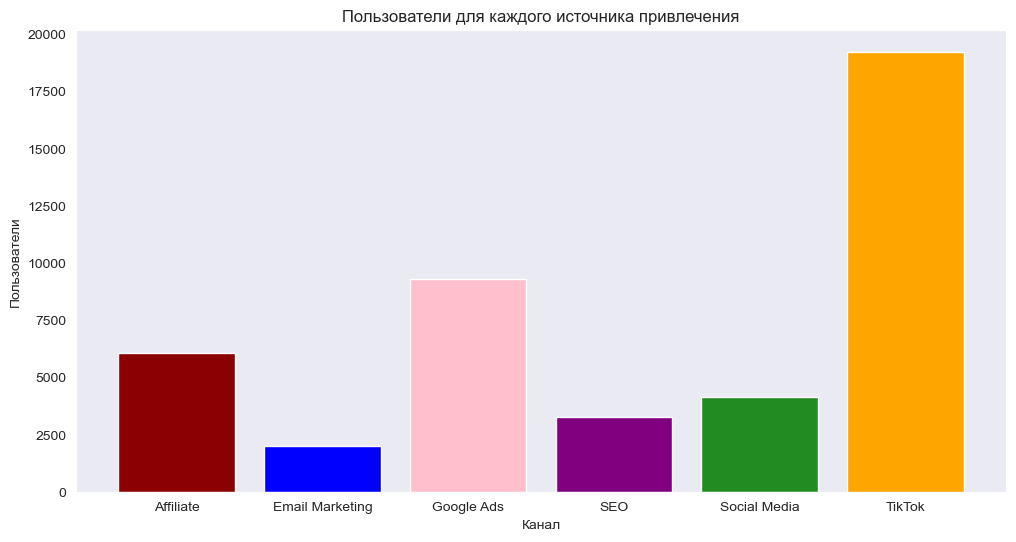

In [48]:
#Сгруппируем данные по когорте и каналу привлечения
new_users_channel_all = users_df.groupby(['cohort_month', 'acq_channel'])['user_id'].nunique().reset_index().rename(columns={'user_id':'count_user'})

#Посчитаем пользователей, привлеченных с каждого канала за год
new_users_channel = new_users_channel_all.groupby('acq_channel')['count_user'].sum().reset_index()

#Строим график
plt.figure(figsize=(12,6))
plt.bar(new_users_channel['acq_channel'], new_users_channel['count_user'], color=channels.values())
plt.title('Пользователи для каждого источника привлечения')
plt.xlabel('Канал')
plt.ylabel('Пользователи')
plt.grid()
plt.show()

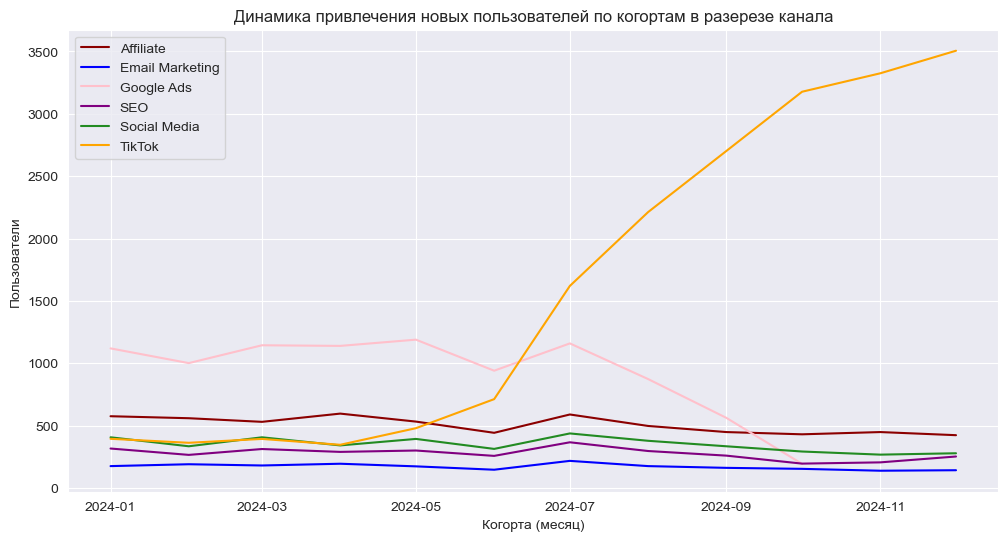

In [49]:
#Строим график через цикл набора пользователей по дням
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    df = new_users_channel_all[new_users_channel_all['acq_channel']== channel]
    plt.plot(df['cohort_month'], df['count_user'], color=color, label=f'{channel}')

plt.title('Динамика привлечения новых пользователей по когортам в разерезе канала')
plt.legend()
plt.xlabel('Когорта (месяц)')
plt.ylabel('Пользователи')
plt.grid(True)
plt.show()

По графикам заметно, что самую большую часть пользователей в маркетплейс привлекли с канала `TikTok`.

В первом полугодии также видно, что самое большое количество пользователей привлекали с канала `Google Ads`. Во втором полугодии возможно начали сокращать бюджет на привлечение с этого канала, т.к. с ноября новых пользователей оттуда уже не было. По остальным каналам набор пользователей за все время стабилен, для канала `TikTok` увеличение началось с апреля.

Посмотрим на показатели вовлеченности пользователей в разрезе канала привлечения:

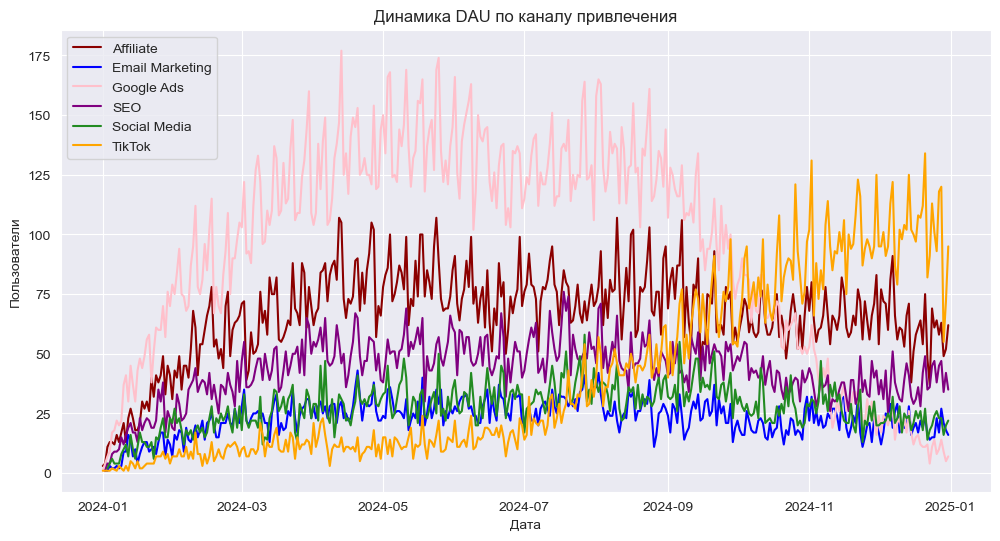

In [50]:
#Присоединим к событиям пользователей дату их когорты и канал привлечения
activity = pd.merge(events_df, users_df[['user_id', 'acq_channel', 'cohort_month']], on='user_id')

#Сгруппируем данные по дням событий и каналу, посчитаем уникальных пользователей
dau_channel = activity.groupby(['event_date', 'acq_channel'])['user_id'].nunique().reset_index()

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    dau_channel_df = dau_channel[dau_channel['acq_channel']== channel]
    plt.plot(dau_channel_df['event_date'], dau_channel_df['user_id'], color=color, label=f'{channel}')

plt.title('Динамика DAU по каналу привлечения')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.grid(True)
plt.show()

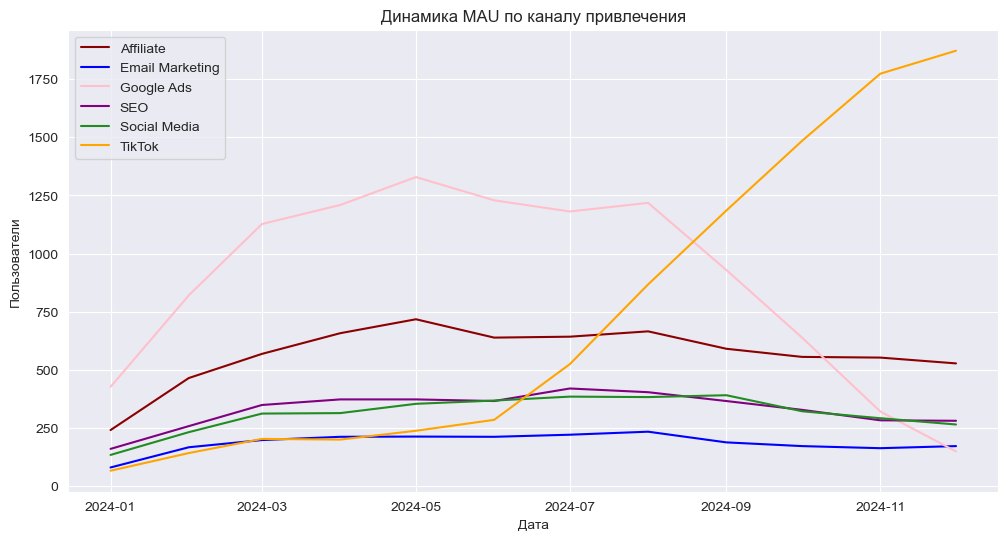

In [51]:
#Сгруппируем данные по месяцу событий и каналу, посчитаем уникальных пользователей
mau_channel = activity.groupby(['event_month', 'acq_channel'])['user_id'].nunique().reset_index()

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    mau_channel_df = mau_channel[mau_channel['acq_channel']== channel]
    plt.plot(mau_channel_df['event_month'], mau_channel_df['user_id'], color=color, label=f'{channel}')

plt.title('Динамика MAU по каналу привлечения')
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.grid(True)
plt.show()

После изучения графиков с уникальными пользователями по дням и по месяцам, с уверенностью можно сказать, что интерес всех пользователей со всех каналов примерно стабильный, кроме пользователей с каналов `Google Ads` и `TikTok`.

До сентября самыми вовлеченными в продукт можно было назвать пользователей, привлеченных с `Google Ads`, после сентября - с канала `TikTok`.

Посмотрим на динамику конверсии из шага `add_to_cart` в оформление заказа `checkout_start` по месячным когортам в разрезе канала:

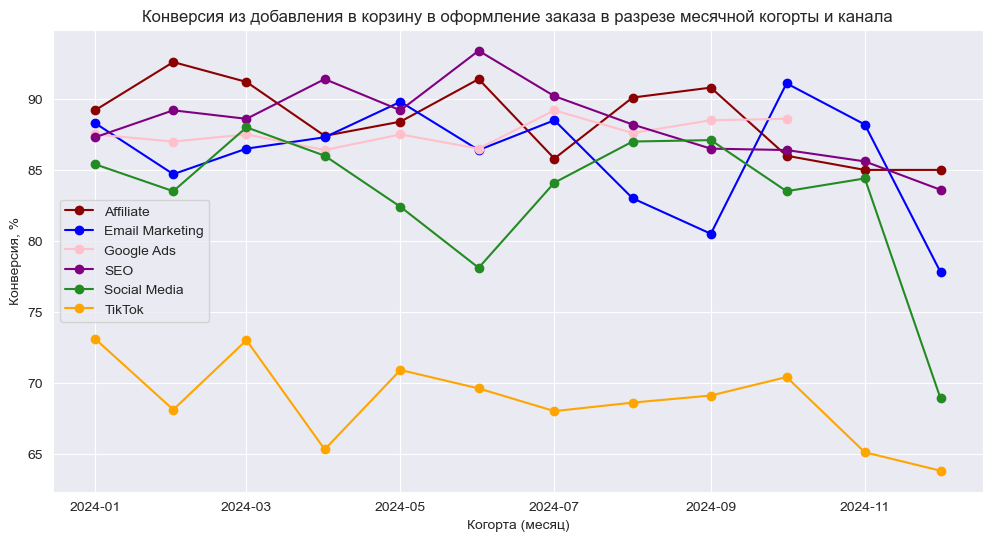

In [52]:
#Зададим порядок шагов в воронке
funnel_step = ['add_to_cart', 'checkout_start']

#Отфильтруем датафрейм по шагам
funnel_count_event_channel = activity[activity['event_type'].isin(funnel_step)]

#Считаем число пользователей на каждом шаге в разрезе когорты и канала
funnel_count_event_channel = funnel_count_event_channel.groupby(['cohort_month', 'acq_channel', 'event_type'])['user_id'].nunique().reset_index().rename(columns={'user_id':'count_users'})

#Соберем таблицу воронки
funnel_event_channel = funnel_count_event_channel.pivot_table(
    index= ['cohort_month', 'acq_channel'],
    columns = 'event_type',
    values = 'count_users'). reset_index()

#Переименуем колонки
funnel_event_channel.rename(columns={'add_to_cart':'users_add_to_cart', 'checkout_start':'users_checkout_start'}, inplace=True)

#Добавим конверсию и округлим до 1 знака после запятой
funnel_event_channel['conversion_%'] = (
            funnel_event_channel['users_checkout_start'] / funnel_event_channel['users_add_to_cart'] * 100).round(1)

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    cr_df = funnel_event_channel[funnel_event_channel['acq_channel']== channel]
    plt.plot(cr_df['cohort_month'], cr_df['conversion_%'], color=color, marker='o', label=f'{channel}')

plt.xlabel('Когорта (месяц)')
plt.ylabel('Конверсия, %')
plt.title('Конверсия из добавления в корзину в оформление заказа в разрезе месячной когорты и канала')
plt.legend()
plt.show()

Учитывая увеличившийся поток пользователей с канала `TikTok` с летних месяцев, конверсия в оформление заказа при этом не увеличилась. Для каналов `Affiliate`, `Google Ads` конверсия была примерно на одном уровне, для `Email Marketing`, `SEO` и `Social Media` - нестабильная, со скачками.

Посчитаем LTV пользователей в разрезе когорты и канала привлечения:

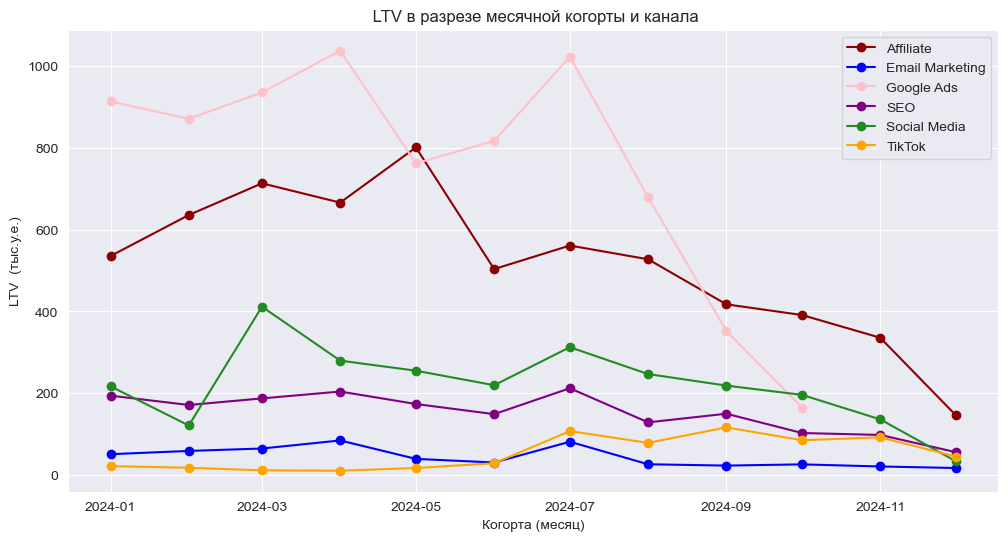

In [53]:
#Для каждой когорты рассчитываем сумму дохода с пользователя - LTV
ltv_sum_channel = ltv.groupby(['cohort_month', 'acq_channel'])['comission'].sum().reset_index().rename(columns={'comission':'ltv_channel'})

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    ltv_df = ltv_sum_channel[ltv_sum_channel['acq_channel']== channel]
    plt.plot(ltv_df['cohort_month'], ltv_df['ltv_channel']/1000, color=color, marker='o', label=f'{channel}')

plt.title(' LTV в разрезе месячной когорты и канала')
plt.xlabel('Когорта (месяц)')
plt.ylabel('LTV  (тыс.у.е.)')
plt.legend()
plt.show()

По графику LTV пользователей в разрезе месячной когорты и канала видно, что самую большую ценность приносили пользователи с каналов `Google Ads` и `Affiliate`, затем `Social Media`, `SEO` и примерно на одном уровне `TikTok` и `Email Marketing`.
Учитывая большой приток пользователей с канала `TikTok` во втором полугодии - денег больше, к сожалению, бизнесу они приносить не стали.

Посмотрим месячные затраты на привлечения пользователя(САС) в разрезе канала:

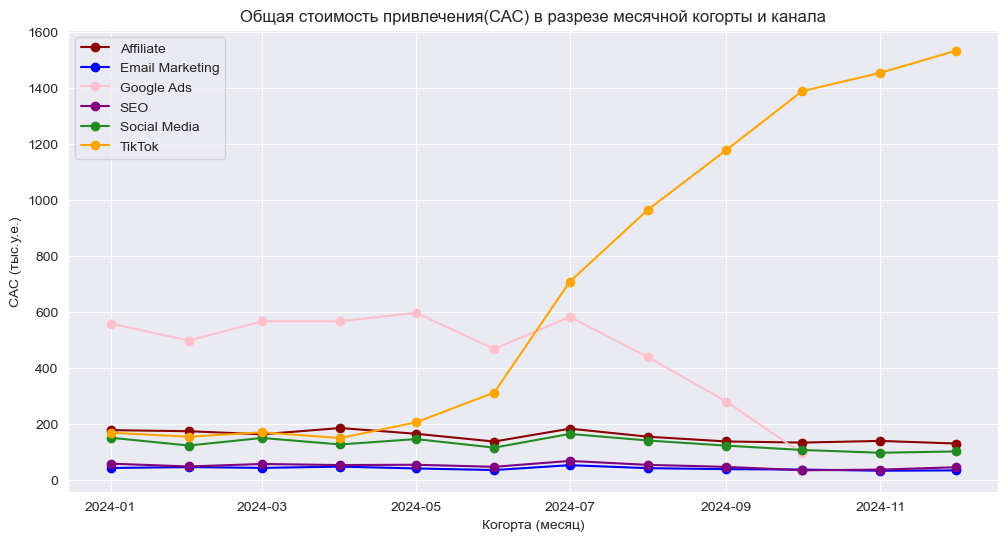

In [54]:
cac_channel = campaign_costs.copy().rename(columns={'spend_month':'cohort_month', 'budget':'cac_channel'})

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    cac_channel_df = cac_channel[cac_channel['acq_channel']== channel]
    plt.plot(cac_channel_df['cohort_month'], cac_channel_df['cac_channel']/1000, color=color, marker='o', label=f'{channel}')

plt.title('Общая стоимость привлечения(САС) в разрезе месячной когорты и канала')
plt.xlabel('Когорта (месяц)')
plt.ylabel('САС (тыс.у.е.)')
plt.legend()
plt.show()

По графику общей **стоимости привлечения (САС) в разрезе месяца и канала** можно заметить, что бюджет на каналы особо не менялся, кроме двух - `Google Ads` и `TikTok`. В апреле команда маркетплейса решила добавить бюджета на привлечение пользователей из `TikTok`, увеличивая его каждый месяц до конца года. Каналу `Google Ads` видимо сократили финансирование и с июля количество средств, затрачиваемых на этот канал, начало уменьшаться. В ноябре и декабре средства для привлечения новых пользователей на этот канал не выделялись. Также можно заметить, что стоимость привлечения для каналов `Affiliate` (≈ 158 тыс. у.е.), `SEO` (≈ 51 тыс. у.е.), `Social Media` (≈ 130 тыс. у.е.), `Email Marketing` (≈ 42 тыс. у.е.) за все время также осталась относительно стабильна, у `Google Ads` в первом полугодии тратили в среднем 540 тыс. у.е., во втором - 350 тыс.у.е. . Для канала `TikTok` в первом полугодии тратили в среднем 190 тыс. у.е., во втором - 1200 тыс. у.е.

Посмотрим окупаемость(ROI) пользователей каждой когорты по месяцам в разрезе канала:

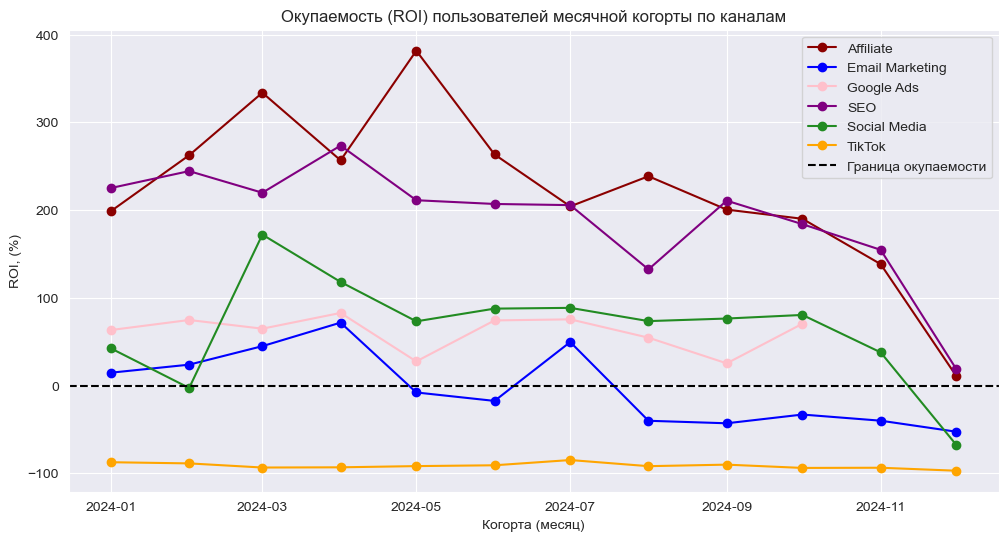

In [55]:
#Создаем новый датафрейм на основе ltv_sum_channel и cac_channel для расчета окупаемости когорт
roi_channel = pd.merge(ltv_sum_channel, cac_channel, on=['cohort_month', 'acq_channel'])

#Посчитаем ROI
roi_channel['ROI_channel'] = (roi_channel['ltv_channel']-roi_channel['cac_channel'])/roi_channel['cac_channel'] *100

#Строим график через цикл
plt.figure(figsize=(12,6))

for channel, color in channels.items():
    roi_channel_df = roi_channel[roi_channel['acq_channel']== channel]
    plt.plot(roi_channel_df['cohort_month'], roi_channel_df['ROI_channel'], color=color, marker='o', label=f'{channel}')

#Добавим горизонтальную линию — границу окупаемости
plt.axhline(y=0, color='black', linestyle='--', label='Граница окупаемости')
plt.title('Окупаемость (ROI) пользователей месячной когорты по каналам')
plt.xlabel('Когорта (месяц)')
plt.ylabel('ROI, (%)')
plt.legend()
plt.grid(True)
plt.show()

Из графика видно, что пользователи из каналов `Affiliate`(≈ 240%), `SEO`(≈ 200%), `Social Media`(≈ 80%)и `Google Ads`(≈ 60%) всегда окупаются (кроме последнего месяца - просто не набрано еще достаточного объема данных по покупкам пользователей за последующие месяцы). Хуже всего окупаются пользователи канала `TikTok` и `Email Marketing`. Но если трафик с `Email Marketing`(≈ 2%) иногда окупался, то трафик с `TikTok` не окупался никогда (≈ -90%).




### Обзор пользователей маркетплейса в разрезе используемого устройства

Посмотрим на конверсию по шагам для пользователей в разрезе девайса:

In [56]:
#Зададим порядок шагов в воронке
funnel_step = ['page_view', 'product_view', 'product_click', 'add_to_cart', 'checkout_start',  'checkout_complete']

In [57]:
#Объединим датафреймы с событиями
events_users = pd.merge(events_df, users_df[['user_id', 'region']], on='user_id')

#Выделим необходимые шаги из датафрейма
funnel_count_device = events_users[events_users['event_type'].isin(funnel_step)]

#Считаем число уникальных пользователей на каждом шаге
funnel_count_device = funnel_count_device.groupby(['device', 'event_type'])['user_id'].nunique().reset_index()

#Соберем таблицу воронки
funnel_device  = funnel_count_device.pivot_table(
    index='device',
    columns='event_type',
    values='user_id')

#Упорядочим столбцы по порядку шагов
funnel_device = funnel_device.reindex(columns=funnel_step)

#Посчитаем конверсию от первого шага
conversion_from_first_device = (funnel_device.div(funnel_device['page_view'], axis=0) * 100).round(2)

#Создадим пустой датафрейм с сохраненными индексами строк от funnel_device
conversion_from_previous_device = pd.DataFrame(index=funnel_device.index)

#Посчитаем конверсию от предыдущего шага
for i, step in enumerate(funnel_step):
    if i == 0:
        conversion_from_previous_device[step] = 100.0    #первый шаг всегда 100%
    else:
        previous_step = funnel_step[i-1]     #текущий шаг делим на предыдущий
        conversion_from_previous_device[step] = ((
            funnel_device[step] / funnel_device[previous_step] * 100).round(2))

conversion_from_first_device= conversion_from_first_device.reset_index()
conversion_from_previous_device = conversion_from_previous_device.reset_index()

#Выведем конверсию от первого шага по девайсам
conversion_from_first_device.head()

event_type,device,page_view,product_view,product_click,add_to_cart,checkout_start,checkout_complete
0,desktop,100.0,99.83,98.31,92.15,76.33,63.77
1,mobile,100.0,99.86,98.44,92.10,74.75,61.67
2,tablet,100.0,99.90,98.37,92.46,75.60,62.18


In [58]:
#Выведем конверсию от предыдущего шага по девайсам
conversion_from_previous_device.head()

,device,page_view,product_view,product_click,add_to_cart,checkout_start,checkout_complete
0,desktop,100.0,99.83,98.47,93.73,82.83,83.55
1,mobile,100.0,99.86,98.57,93.56,81.17,82.50
2,tablet,100.0,99.90,98.47,93.99,81.77,82.24


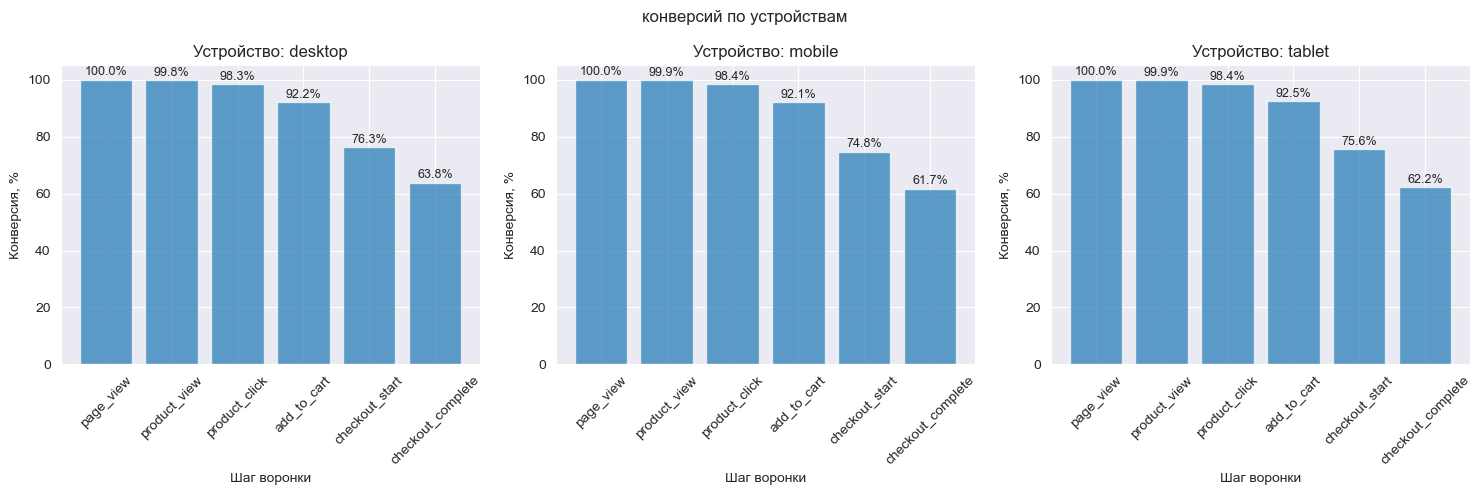

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Шаги воронки
steps = conversion_from_first_device.columns[1:].tolist()

# Проходим по всем устройствам
for i in range(len(conversion_from_first_device)):
    # Берем данные для i-го устройства
    device = conversion_from_first_device['device'].iloc[i]
    values = conversion_from_first_device.iloc[i, 1:].tolist()

    # Строим график (как в примере)
    bars = axes[i].bar(steps, values, alpha=0.7)
    axes[i].set_title(f"Устройство: {device}")
    axes[i].set_xlabel('Шаг воронки')
    axes[i].set_ylabel('Конверсия, %')

    # Можно добавить значения на столбцы (опционально)
    for bar, value in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2,
                    bar.get_height() + 0.5,
                    f'{value:.1f}%',
                    ha='center', va='bottom', fontsize=9)

    # Поворачиваем подписи
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('конверсий по устройствам')
plt.tight_layout()
plt.show()

Заметно, что самая низкая конверсия на шаге `add_to_cart` в `checkout_start`, а затем в `checkout_complete` на устройстве `mobile`.

Посмотрим на динамику выручки по заказам в разрезе устройства:

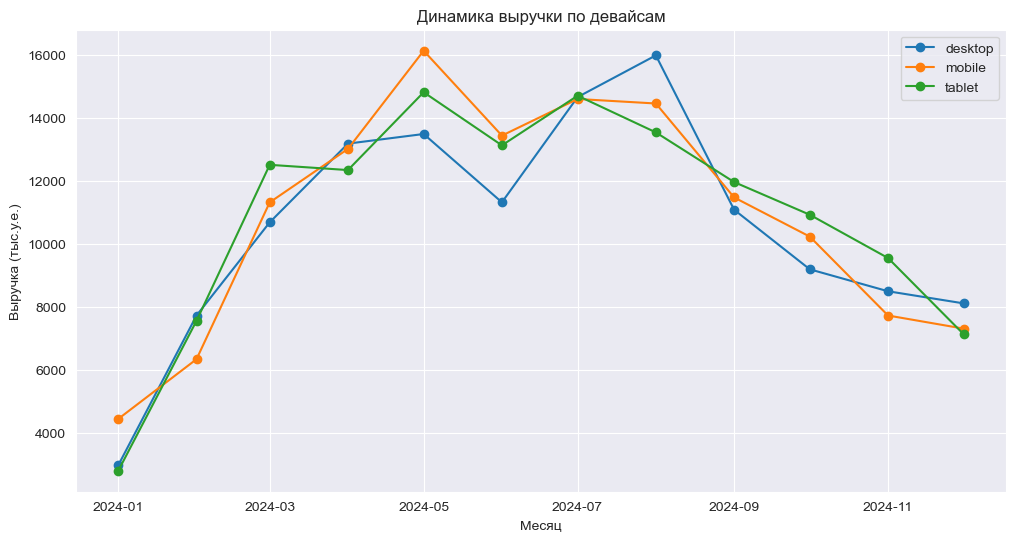

In [60]:
#Сгруппируем события пользователя по идентификатору и девайсу
users_devices = events_df.groupby(['user_id', 'device']).nunique().reset_index()

#Присоединим к заказам пользователей их устройство
events_users_revenue = pd.merge(users_devices, orders_df[['user_id', 'order_month', 'total_price']], on='user_id')

#Посчитаем выручку с заказов по утсройствам
gmv_device = events_users_revenue.groupby(['device', 'order_month'])['total_price'].sum().reset_index().rename(columns={'total_price':'gmv'})

#Строим график через цикл
plt.figure(figsize=(12,6))

for device in gmv_device['device'].unique():
    gmv_device_df = gmv_device[gmv_device['device']== device]
    plt.plot(gmv_device_df['order_month'], gmv_device_df['gmv']/1000, marker='o', label=f'{device}')

plt.title('Динамика выручки по девайсам')
plt.xlabel('Месяц')
plt.ylabel('Выручка (тыс.у.е.)')
plt.legend()
plt.show()

Особых каких-то спадов по выручке для мобильных устройств нет. Следовательно, затруднения в начале оформления заказа (`checkout_start`) у пользователей и его завершение (`checkout_complete`) не зависит от устройства.

Возможно надо провести улучшения на страничке оформления заказа (`checkout_start`) для повышения конверсии в дальнейшую покупку.

### Обзор пользователей маркетплейса в разрезе покупательского сегмента

Проанализируем предоставленные в данных покупательские сегменты, начнем с конверсии по пользовательскому пути:


In [61]:
#КОНВЕРСИЯ ПО ПОКУПАТЕЛЬСКОМУ СЕГМЕНТУ
#Объединим события пользователя с его покупательским сегментом
events_users_buyer_segment = pd.merge(events_df, users_df[['user_id', 'buyer_segment']], on='user_id')
#Зададим порядок шагов в воронке
funnel_step = ['page_view', 'product_view', 'product_click', 'add_to_cart', 'checkout_start',  'checkout_complete']

funnel_count_event_buyer_segment = events_users_buyer_segment[events_users_buyer_segment['event_type'].isin(funnel_step)]

#Считаем число новых уникальных пользователей на каждом шаге
funnel_count_event_buyer_segment = funnel_count_event_buyer_segment.groupby(['buyer_segment', 'event_type'])['user_id'].nunique().reset_index()


#Соберем таблицу воронки
funnel_event_buyer_segment  = funnel_count_event_buyer_segment.pivot_table(
    index='buyer_segment',
    columns='event_type',
    values='user_id')

#Упорядочим столбцы по порядку шагов
funnel_event_buyer_segment = funnel_event_buyer_segment.reindex(columns=funnel_step)

#Посчитаем конверсию от первого шага
conversion_from_first_buyer_segment = (funnel_event_buyer_segment.div(funnel_event_buyer_segment['page_view'], axis=0) * 100).round(2)

#Создадим пустой датафрейм с сохраненными индексами строк от funnel_event_device
conversion_from_previous_buyer_segment = pd.DataFrame(index=funnel_event_buyer_segment.index)

#Посчитаем конверсию от предыдущего шага
for i, step in enumerate(funnel_step):
    if i == 0:
        conversion_from_previous_buyer_segment[step] = 100.0
    else:
        previous_step = funnel_step[i-1]
        conversion_from_previous_buyer_segment[step] = (
            (funnel_event_buyer_segment[step] / funnel_event_buyer_segment[previous_step] * 100).round(2))

#Выведем конверсию от первого шага по девайсам
conversion_from_first_buyer_segment.head()

event_type,page_view,product_view,product_click,add_to_cart,checkout_start,checkout_complete
buyer_segment,,,,,,
medium,100.0,99.89,98.42,93.23,77.73,65.12
one_time,100.0,99.77,96.52,82.84,52.94,35.09
rare,100.0,99.75,97.85,88.28,64.56,47.34
regular,100.0,99.96,99.29,96.90,88.81,80.64


In [62]:
conversion_from_previous_buyer_segment.head()

,page_view,product_view,product_click,add_to_cart,checkout_start,checkout_complete
buyer_segment,,,,,,
medium,100.0,99.89,98.52,94.73,83.37,83.78
one_time,100.0,99.77,96.75,85.83,63.90,66.28
rare,100.0,99.75,98.10,90.22,73.13,73.34
regular,100.0,99.96,99.32,97.60,91.65,90.80


Логично, что конверсия в оформление и покупку снижается в зависимости от сегмента. Самая низкая конверсия на стадиях  из `add_to_cart` в `checkout_start` и потом в `checkout_complete` для сегмента one_time (52,94% и 35,09% соответственно). Для сегмента rare - 64,56% и 47,34%, для medium - 77,73% и 65,12%, для regular - 88,81% и 80,64%.

Посмотрим выручку и количество заказов с пользователей в разрезе покупательского сегмента:

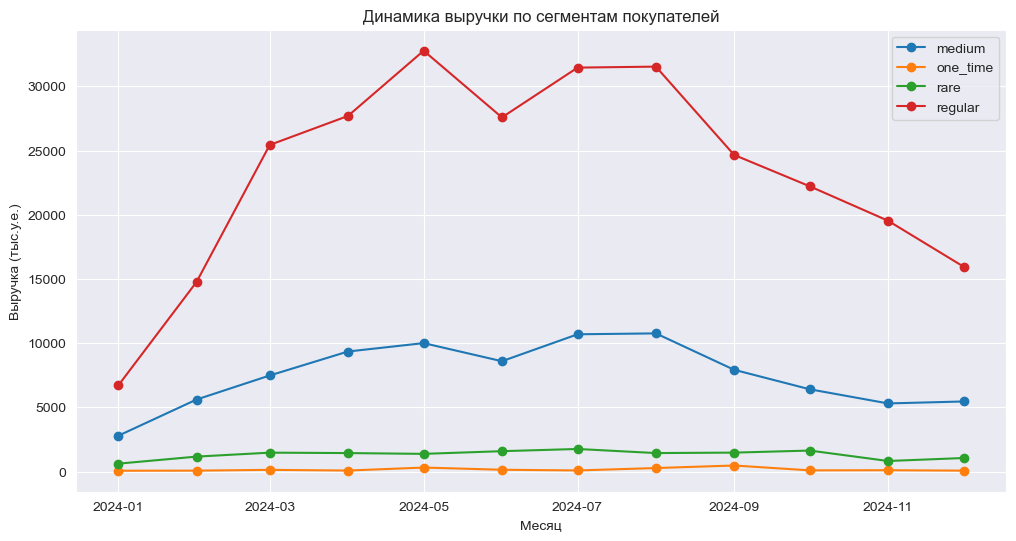

In [63]:
#Объединим заказы пользователей с их когортой и покупательским сегментом
orders_buyer_segment = pd.merge(orders_df, users_df[['user_id', 'cohort_month', 'buyer_segment']], on='user_id')

#Сгруппируем пользователей по месяцу заказа и сегменту для расчета выручки с заказов
orders_buyer_segment_rev = orders_buyer_segment.groupby(['order_month', 'buyer_segment'])['total_price'].sum().reset_index()

#Строим график через цикл
plt.figure(figsize=(12,6))

for buyer_segment in orders_buyer_segment_rev['buyer_segment'].unique():
    segment_rev_df = orders_buyer_segment_rev[orders_buyer_segment_rev['buyer_segment']== buyer_segment]
    plt.plot(segment_rev_df['order_month'], segment_rev_df['total_price']/1000, marker='o', label=f'{buyer_segment}')

plt.title('Динамика выручки по сегментам покупателей')
plt.xlabel('Месяц')
plt.ylabel('Выручка (тыс.у.е.)')
plt.legend()
plt.show()

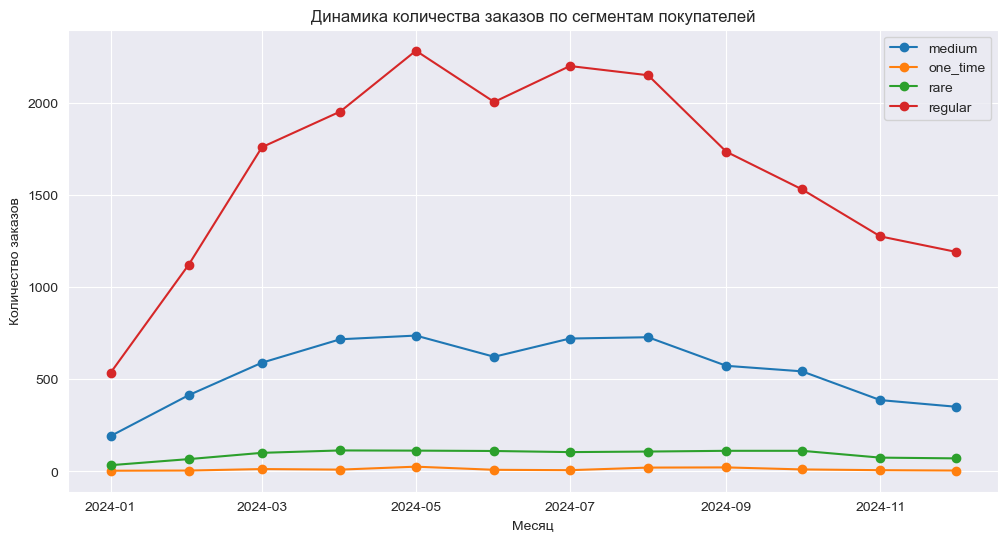

In [64]:
#Сгруппируем пользователей по месяцу заказа и сегменту для расчета количества заказов
orders_buyer_segment_count = orders_buyer_segment.groupby(['order_month', 'buyer_segment'])['order_id'].count().reset_index()

#Строим график через цикл
plt.figure(figsize=(12,6))

for buyer_segment in orders_buyer_segment_count['buyer_segment'].unique():
    segment_count_order_df = orders_buyer_segment_count[orders_buyer_segment_count['buyer_segment']== buyer_segment]
    plt.plot(segment_count_order_df['order_month'], segment_count_order_df['order_id'], marker='o', label=f'{buyer_segment}')

plt.title('Динамика количества заказов по сегментам покупателей')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Можно заметить, что для сегментов regular и medium с начала года до мая выручка и количество заказов росли, затем с июля по август была стагнация, после чего началось снижение. С менее активными сегментами покупателей (rare и one_time) ситуация стабильная.

Посмотрим на удержание пользователей в повторную покупку в течение 30 дней в разрезе месячной когорты и сегмента покупателя:

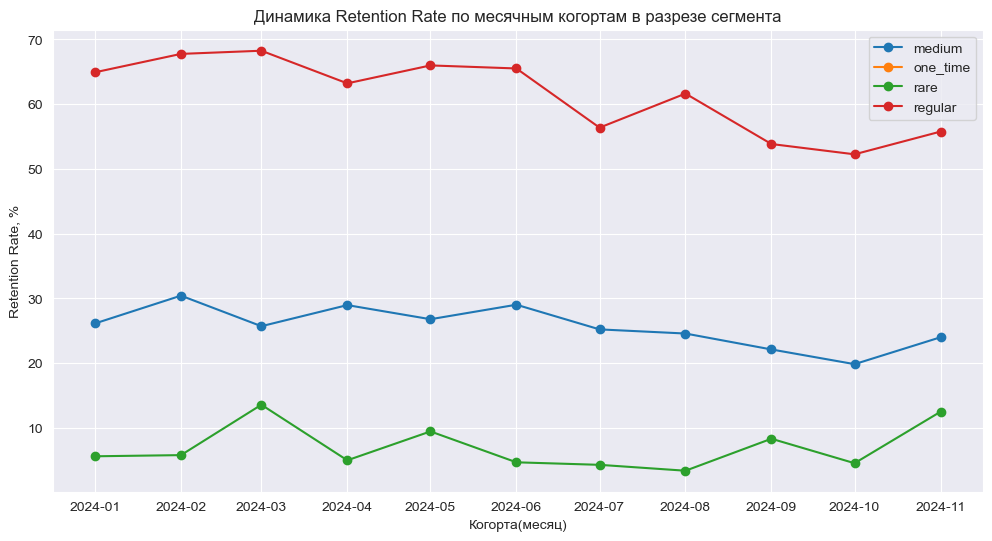

In [65]:
rr_segment = orders_buyer_segment.copy()

#Найдем дату первой покупки
rr_segment['first_order'] = rr_segment.groupby('user_id')['order_date'].transform('min')

#Вычислим лайтайм для пользователей по покупкам
rr_segment['lifetime'] = (rr_segment['order_date'] - rr_segment['first_order']).dt.days
rr_segment['first_order'] = pd.to_datetime(rr_segment['first_order']).dt.normalize()

#Ограничим выборку по времени, чтобы не попали в данные пользователи позже этой даты, т.к. для них не наберется достаточно данных
end_date = '2024-12-01'

#Фильтруем датасет до первых покупок и когорт не позже декабря
rr_segment_all_users = rr_segment[(rr_segment['first_order'] < end_date) & (rr_segment['cohort_month'] < end_date)]

#Считаем уникальных пользователей в разрезе месячной когорты и покупательского сегмента
rr_segment_all_users = rr_segment_all_users.groupby(['cohort_month', 'buyer_segment'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'all_users'})

#Фильтруем датасет до первых покупок не позже начала декабря и когорт не позже декабря с лайфтоймом в 30 дней
rr_segment_30_days = rr_segment[(rr_segment['first_order'] < end_date) & (rr_segment['cohort_month'] < end_date) & (rr_segment['lifetime'] <= 29) & (rr_segment['lifetime'] > 0)]

#Считаем уникальных пользователей в разрезе месячной когорты и покупательского сегмента на повторную покупку
rr_segment_30_days = rr_segment_30_days.groupby(['cohort_month', 'buyer_segment'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'returned_users'})

#Соединим два датасета с общим кол-вом уников и кол-вом уников за период 30 дней
rr_segment_30 = pd.merge(rr_segment_all_users, rr_segment_30_days, how='left', on=['cohort_month', 'buyer_segment'])

#Посчитаем метрику Retention Rate
rr_segment_30['RR'] = ((rr_segment_30['returned_users']/rr_segment_30['all_users']) * 100).round(2)

#Строим график через цикл
plt.figure(figsize=(12,6))

for segment in rr_segment_30['buyer_segment'].unique():
    rr_segment_30_df = rr_segment_30[rr_segment_30['buyer_segment']== segment]
    plt.plot(rr_segment_30_df['cohort_month'], rr_segment_30_df['RR'], marker='o', label=f'{segment}')

plt.title('Динамика Retention Rate по месячным когортам в разрезе сегмента')
plt.xlabel('Когорта(месяц)')
plt.ylabel('Retention Rate, %')
plt.legend()
plt.grid(True)
plt.xticks(rotation=0)
plt.show()

Удержание пользователей (Retention Rate) в повторную покупку в течение 30 дней для сегментов покупателей показывает тренд на снижение после июня - для regular с 65% до 55%, для medium с 29% до 22%, для rare стабильно в течение года в районе 5%, за исключением нескольких месяцев.

По итогу анализа в разрезе покупательских сегментов выявлены проблемы с удержанием regular и medium - в летние месяцы наблюдалась стагнация, с осени покупатели стали меньше заказывать и возвращаться за повторными покупками по сравнению с пользователями первого полугодия.

## Выводы по блоку "Поиск инсайтов, точек роста и сегментация"

При анализе данных предоставленных маркетплейсом были найдены проблемы в разрезах каналов привлечения, девайсов пользователей и покупательских сегментах.

*Каналы привлечения*

1) Эффективные каналы, которые можно масштабировать
- Пользователи с каналов `Affiliate`, `SEO` и `Social Media` показали хорошие результаты. Для `Affiliate` — ROI ≈240%, средний CAC (≈ 158 тыс. у.е.), высокий LTV, для `SEO` - ROI ≈200%, низкий CAC (51 тыс. у.е), канал `Social Media` - ROI ≈80%, средний CAC (130 тыс. у.е).

2) Неэффективные каналы, для которых нужна оптимизация
- Пользователи с канала `TikTok` самые убыточные - ROI ≈(-90%) при огромном росте стоимости на привлечение (САС) **во втором полугодии** (в среднем 1200 тыс. у.е. в месяц) и увеличении трафика пользователей (19228 человек за год). Ключевая проблема: аудитория низкого качества.
- Пользователи с канала `Email Marketing` - не всегда окупаются при затратах на привлечение порядка 42 тыс. у.е.
- Пользователи с канала `Google Ads` - показывал стабильную окупаемость и высокий LTV пользователей, но в октябре от этого канала привлечения отказались.

Рекомендации по оптимизации каналов:

1) Увеличить бюджеты на привлечение пользователей с каналов `Affiliate` и `SEO`.

2) Оптимизировать рекламные кампании, связанные с каналом `Email Marketing`, так как имеются проблемы с окупаемостью вложений.

3) Приостановить масштабирование аудитории маркетплейса пользователями с канала `TikTok`, т.к. самый убыточный. Пересмотреть бюджет на этот канал и направить средства на расширение других, более перспективных.

4) Частично восстановить бюджет на пользователей из `Google Ads`, т.к. аудитория с этого канала была с самой большой вовлеченностью, а также хорошо окупалась.

Гипотеза: "Если перенаправить половину бюджета с TikTok на Affiliate, то общая ROI маркетинга вырастет"

*Пользователи в разрезе используемого устройства*

Проведенный анализ воронки конверсий пользовательского пути выявил ключевую проблемную зону: наибольший отток пользователей происходит на этапе перехода от добавления товара в корзину (`add_to_cart`) к началу оформления заказа (`checkout_start`). Самая маленькая конверсия у пользователей мобильных устройств - 81,17% от предыдущего шага.

Гипотеза: "Оптимизация пользовательского интерфейса страницы оформления заказа (`checkout_start`) увеличит конверсию в начало оформления и в завершение оформления (`checkout_complete`)."

*Пользователи в разрезе покупательского сегмента*

Выявлены проблемы с удержанием покупательских сегментов пользователей regular и medium. После периода роста в первом полугодии наблюдается стагнация в летние месяцы с последующим снижением покупательской активности и удержания(Retention Rate) в повторную покупку в течение 30 дней (для regular падение на 10%, для medium - на 7%). При этом менее активные сегменты (rare и one_time) остаются стабильно неактивными.

Рекомендации по оптимизации удержания покупательских сегментов:

1) Разработать программу лояльности с кешбэками/бонусами для сегментов regular и medium для повышения удержания пользователей

2) Внедрить персональные акции для сегмента rare для реанимации и возврата пользователя в маркетплейс

Гипотеза: "Внедрение программы лояльности с бонусами для сегментов regular и medium увеличит удержание пользователей в повторную покупку."


## 5. Подготовка эксперимента и подведение его результатов


Команда продукта рассмотрела гипотезы, предложенные аналитиком (автором проекта), и на основании этого решила влиять на конверсию при помощи финансовых стимуляций. Так как ситуация со снижением выручки срочная и безотлагательная, они подключили другого аналитика для подготовки дизайн документа. Необходимо подготовить выводы по эксперименту.


# Дизайн эксперимента:

Бонус на первую покупку для пользователей TikTok

## 1. Контекст и цель эксперимента

- **Бизнес-контекст:** Команда продукта запускает эксперимент, направленный на повышение конверсии среди пользователей, привлечённых через канал TikTok. Для стимулирования первой покупки пользователям будет предоставлен бонус на первую покупку.  
- **Цель:** Проверить, влияет ли предоставление бонуса на первую покупку на конверсию и выручку среди пользователей TikTok.  
- **Гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку

---

## 2. Формат эксперимента

- **Тип эксперимента:** Сплит-роллинг (rolling split)  
- **Канал:** Только пользователи, пришедшие с TikTok  
- **Группы:**  
  - **Контрольная (A):** пользователи TikTok без бонуса  
  - **Тестовая (B):** пользователи TikTok с бонусом на первую покупку  
- **Распределение:** Равномерное распределение новых пользователей TikTok между группами по дате регистрации  
- **Период проведения:** 3 недели (фиксировано)

---

## 3. Ключевые метрики

### Основная метрика

- **Конверсия в первую покупку** — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку  
  - *Цель:* увеличить конверсию с помощью бонуса  
  - *Критерий успеха:* статистически значимый рост конверсии в тестовой группе

### Вспомогательные метрики

- **ARPU** (средняя выручка на пользователя TikTok)  
- **ARPPU** (средняя выручка на покупателя TikTok)  
- **AOV** (средний чек TikTok)

### Барьерная метрика

- **Общая выручка от пользователей TikTok**

---

## 4. Размеры групп и запуск

- **Целевая аудитория:** только пользователи TikTok  
- **Размеры групп:** определяются по фактическому трафику TikTok за период эксперимента  
- **Комментарий:** запуск без предварительного расчёта мощности и MDE из-за срочности задачи


## Загрузка и предобработка данных
Загрузим данные информацией о пользователях, событиях, заказах, сессиях, а также результаты эксперимента. Проведем предобработку, основную информацию зафиксируем в промежуточном выводе.


In [66]:
#Выгрузим данные по пользователям эксперимента
users_ab = pd.read_csv('./data/tests/pa_diploma_users_AB.csv', parse_dates=['registration_date', 'cohort_week', 'cohort_month'])
orders_ab = pd.read_csv('./data/tests/pa_diploma_orders_AB.csv', parse_dates=['order_date', 'order_week', 'order_month'])
events_ab = pd.read_csv('./data/tests/pa_diploma_events_AB.csv',  parse_dates=['event_date', 'event_week', 'event_month'])
sessions_ab = pd.read_csv('./data/tests/pa_diploma_sessions_AB.csv', parse_dates=['session_start', 'session_week', 'session_month'])

#Выгрузим результаты сплита
split_users = pd.read_csv('./data/tests/pa_diploma_AB_split_users.csv')

Cтоит присоединить к данным пользователей users_ab данные сплита split_users, чтобы оставить информацию только об участниках теста:

In [67]:
#Соединим информацию о пользователях с пользователями эксперимента
users_split = pd.merge(users_ab, split_users, how='inner', on='user_id')
users_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2968 entries, 0 to 2967
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            2968 non-null   int64         
 1   registration_date  2968 non-null   datetime64[ns]
 2   os                 2968 non-null   object        
 3   age                2968 non-null   int64         
 4   device             2968 non-null   object        
 5   gender             2968 non-null   object        
 6   region             2968 non-null   object        
 7   browser            2968 non-null   object        
 8   country            2968 non-null   object        
 9   acq_channel        2968 non-null   object        
 10  campaign_id        2968 non-null   float64       
 11  user_segment       2968 non-null   object        
 12  buyer_segment      2968 non-null   object        
 13  cohort_week        2968 non-null   datetime64[ns]
 14  cohort_m

In [68]:
print(f'Количество явных дубликатов в датафрейме users_split: {users_split.duplicated().sum()}')

#Выясним, какие данные у нас хранятся в датафрейме
user_unique_ab = users_split['user_id'].nunique()
channel_unique_ab = users_split['acq_channel'].unique()
reg_min_ab = users_split['registration_date'].min()
reg_max_ab = users_split['registration_date'].max()
unique_group = users_split['group'].unique()
print(f'В датасете представлено:\n'
      f'- количество уникальных пользователей -{user_unique_ab};\n',
      f'- каналы привлечения - {channel_unique_ab};\n',
      f'- диапазон дат регистраций: {reg_min_ab} - {reg_max_ab};\n',
      f'- названия уникальных групп - {unique_group}.')

Количество явных дубликатов в датафрейме users_split: 0
В датасете представлено:
- количество уникальных пользователей -2968;
 - каналы привлечения - ['TikTok'];
 - диапазон дат регистраций: 2025-01-01 00:05:00 - 2025-01-26 23:41:00;
 - названия уникальных групп - ['control' 'treatment'].


Теперь стоит изучить информацию с точки зрения пересечений в датафреймах. Необходимо исключить из таблицы с заказами тех пользователей, которые не участвовали в эксперименте:


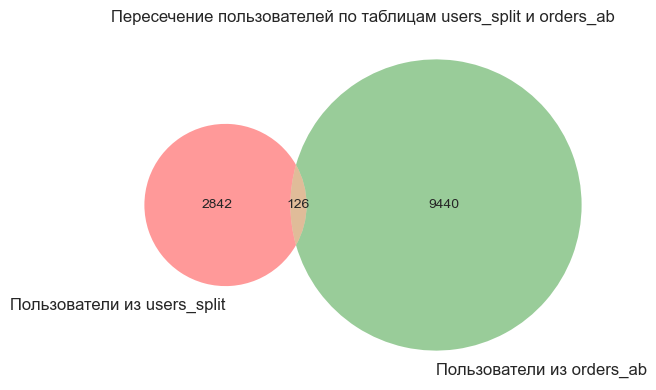

In [69]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_users_ab = set(users_split['user_id'].unique())
users_orders_ab = set(orders_ab['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_users_ab, users_orders_ab], set_labels = ['Пользователи из users_split', 'Пользователи из orders_ab'])
plt.title("Пересечение пользователей по таблицам users_split и orders_ab")
plt.show()

In [70]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_ab_1 = users_users_ab & users_orders_ab
#Отфильтруем пользователей из эксперимента, которые совершали заказ
orders_split = orders_ab[orders_ab['user_id'].isin(intersection_ab_1)]
count_orders_ab = orders_split['user_id'].nunique()
print(f'Количество пользователей из эксперимента, которые совершили покупку и попали в таблицу orders_ab: {count_orders_ab}')
display(orders_split.head(5))

Количество пользователей из эксперимента, которые совершили покупку и попали в таблицу orders_ab: 126


,order_id,user_id,order_date,product_name,quantity,unit_price,total_price,category_name,order_week,order_month
31399,37141,45065,2025-01-01 11:57:43,Цепочка серебряная,3,7202.01,21606.03,Украшения и часы,2024-12-30,2025-01-01
31415,37148,45081,2025-01-01 16:01:22,Куртка детская,2,2156.91,4313.82,Детская одежда,2024-12-30,2025-01-01
31416,37149,45081,2025-01-01 16:01:22,Джинсы детские,1,873.16,873.16,Детская одежда,2024-12-30,2025-01-01
31451,37147,45077,2025-01-02 04:59:13,Корм для кошек,2,851.39,1702.78,Зоотовары,2024-12-30,2025-01-01
31452,37146,45077,2025-01-02 04:59:13,Чай черный,2,239.45,478.90,Продукты питания,2024-12-30,2025-01-01


Теперь изучим отфильтрованный датафрейм с заказами пользователей из эксперимента orders_split:

In [71]:
orders_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 31399 to 33269
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       255 non-null    int64         
 1   user_id        255 non-null    int64         
 2   order_date     255 non-null    object        
 3   product_name   255 non-null    object        
 4   quantity       255 non-null    int64         
 5   unit_price     255 non-null    float64       
 6   total_price    255 non-null    float64       
 7   category_name  255 non-null    object        
 8   order_week     255 non-null    datetime64[ns]
 9   order_month    255 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(3)
memory usage: 21.9+ KB


Колонка с датой заказа `order_date` по какой-то причине не преобразована до типа данных datetime. Её необходимо преобразовать:

In [72]:
#Приведем колонку order_date к стандартному формату даты и времени
orders_split['order_date'] = pd.to_datetime(orders_split['order_date'], format='ISO8601')
orders_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 255 entries, 31399 to 33269
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       255 non-null    int64         
 1   user_id        255 non-null    int64         
 2   order_date     255 non-null    datetime64[ns]
 3   product_name   255 non-null    object        
 4   quantity       255 non-null    int64         
 5   unit_price     255 non-null    float64       
 6   total_price    255 non-null    float64       
 7   category_name  255 non-null    object        
 8   order_week     255 non-null    datetime64[ns]
 9   order_month    255 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(3), object(2)
memory usage: 21.9+ KB


In [73]:
print(f'Количество явных дубликатов в датафрейме orders_split: {orders_split.duplicated().sum()}')

#Выполним проверку интервалов дат
order_min_ab = orders_split['order_date'].min()
order_max_ab = orders_split['order_date'].max()
print(f'Интервал дат в датафрейме orders_split: {order_min_ab} - {order_max_ab}.')

Количество явных дубликатов в датафрейме orders_split: 0
Интервал дат в датафрейме orders_split: 2025-01-01 11:57:43 - 2025-01-26 20:39:35.


Теперь необходимо исключить из таблицы с событиями тех пользователей, которые не участвовали в эксперименте:


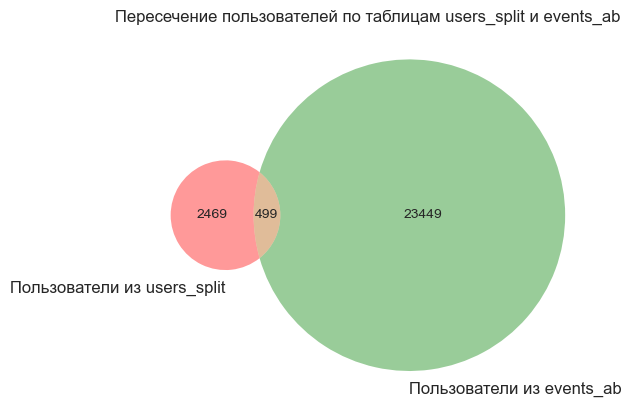

In [74]:
#Создадим множество для диаграммы Венна на основе уникальных id пользователя
users_events_ab = set(events_ab['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_users_ab, users_events_ab], set_labels = ['Пользователи из users_split', 'Пользователи из events_ab'])
plt.title("Пересечение пользователей по таблицам users_split и events_ab")
plt.show()

In [75]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_ab_2 = users_users_ab & users_events_ab
#Отфильтруем пользователей из эксперимента, у которых имеются какие-либо события
events_split = events_ab[events_ab['user_id'].isin(intersection_ab_2)]
count_events_ab = events_split['user_id'].nunique()
print(f'Количество зарегистрированных пользователей из эксперимента, которые совершали хоть какие-то действия на маркетплейсе и попали в таблицу events_ab: {count_events_ab}')
display(events_split.head(5))

Количество зарегистрированных пользователей из эксперимента, которые совершали хоть какие-то действия на маркетплейсе и попали в таблицу events_ab: 499


,event_id,session_id,user_id,event_date,event_type,os,device,event_index,user_segment,product_name,event_week,event_month
787804,844987,135457,45076,2025-01-02 03:25:32,page_view,Android,tablet,1,regular,NaN,2024-12-30,2025-01-01
787806,844988,135457,45076,2025-01-02 03:25:49,product_view,Android,tablet,2,regular,Картина маслом,2024-12-30,2025-01-01
787808,844989,135457,45076,2025-01-02 03:26:23,product_click,Android,tablet,3,regular,Сумка кожаная,2024-12-30,2025-01-01
787809,844990,135457,45076,2025-01-02 03:26:50,add_to_cart,Android,tablet,4,regular,Дезодорант,2024-12-30,2025-01-01
787811,844991,135457,45076,2025-01-02 03:27:11,checkout_start,Android,tablet,5,regular,NaN,2024-12-30,2025-01-01


Посмотрим датафрейм с информацией о событиях пользователей events_ab:

In [76]:
events_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4349 entries, 787804 to 831211
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   event_id      4349 non-null   int64         
 1   session_id    4349 non-null   int64         
 2   user_id       4349 non-null   int64         
 3   event_date    4349 non-null   datetime64[ns]
 4   event_type    4349 non-null   object        
 5   os            4349 non-null   object        
 6   device        4349 non-null   object        
 7   event_index   4349 non-null   int64         
 8   user_segment  4349 non-null   object        
 9   product_name  2335 non-null   object        
 10  event_week    4349 non-null   datetime64[ns]
 11  event_month   4349 non-null   datetime64[ns]
dtypes: datetime64[ns](3), int64(4), object(5)
memory usage: 441.7+ KB


In [77]:
print(f'Количество явных дубликатов в датафрейме events_split: {events_split.duplicated().sum()}')

#Выполним проверку интервалов дат
event_min_ab = events_split['event_date'].min()
event_max_ab = events_split['event_date'].max()
print(f'Интервал дат в датафрейме events_split: {event_min_ab} - {event_max_ab}.')

Количество явных дубликатов в датафрейме events_split: 0
Интервал дат в датафрейме events_split: 2025-01-02 03:25:32 - 2025-01-26 23:46:15.


Странно, что первые заказы пользователей были совершены 1 января, а логирование действий началось только со 2 января. Этот факт необходимо учесть.

Колонка `event_index` вероятнее всего отображает последовательность действий пользователя во время сессии. Пропуски в столбце `product_name` не случайны, так как название позиции товара отображается только при посещении самой странички товара, нажатии на карточку товара или добавления его в корзину.



Теперь необходимо исключить из таблицы с сессиями тех пользователей, которые не участвовали в эксперименте:


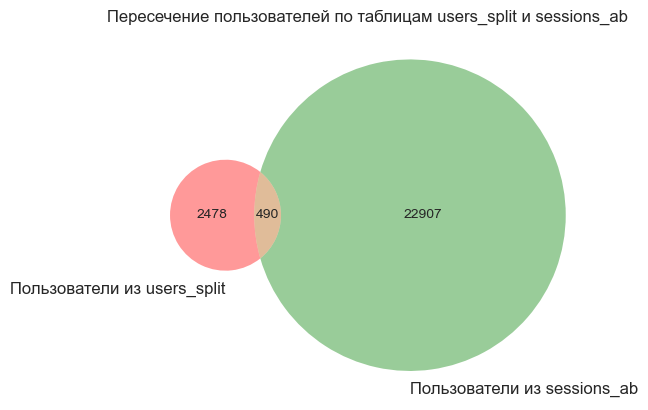

In [78]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_sessions_ab = set(sessions_ab['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_users_ab, users_sessions_ab], set_labels = ['Пользователи из users_split', 'Пользователи из sessions_ab'])
plt.title('Пересечение пользователей по таблицам users_split и sessions_ab')
plt.show()

In [79]:
#Выведем id пользователей, которые имеются в двух датафреймах
intersection_ab_3 = users_users_ab & users_sessions_ab
#Отфильтруем пользователей из эксперимента, у которых были сессии
sessions_split = sessions_ab[sessions_ab['user_id'].isin(intersection_ab_3)]
count_sessions_ab = sessions_split['user_id'].nunique()
print(f'Количество пользователей из эксперимента, у которых были сессии и попали в таблицу sessions_ab: {count_sessions_ab}')
display(sessions_split.head(5))

Количество пользователей из эксперимента, у которых были сессии и попали в таблицу sessions_ab: 490


,session_id,user_id,session_start,os,device,region,browser,country,entry_path,path_start,utm_source,screen_size,scroll_depth,user_segment,utm_campaign_id,session_week,session_month
119858,135457,45076,2025-01-02 03:24:57,Android,tablet,Санкт-Петербург,Edge,Россия,/category,/sale/19,unknown,1920x1080,43,regular,13.0,2024-12-30,2025-01-01
119867,135407,45046,2025-01-02 03:57:06,macOS,tablet,Москва,Firefox,Россия,/category,/click/4,unknown,768x1024,34,medium,37.0,2024-12-30,2025-01-01
120002,135595,45196,2025-01-02 14:45:32,iOS,mobile,Санкт-Петербург,Firefox,Россия,/promo,/recommend/16,unknown,1920x1080,78,medium,43.0,2024-12-30,2025-01-01
120055,135258,44985,2025-01-02 19:37:58,macOS,mobile,Другие регионы,Edge,Россия,/home,/recommend/9,unknown,1920x1080,28,rare,10.0,2024-12-30,2025-01-01
120201,135349,45023,2025-01-03 06:37:59,Android,tablet,Другие регионы,Firefox,Россия,/checkout,/recommend/20,unknown,375x667,67,medium,48.0,2024-12-30,2025-01-01


Изучим датафрейм с сессиями пользователей sessions_split:

In [80]:
sessions_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 812 entries, 119858 to 127402
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   session_id       812 non-null    int64         
 1   user_id          812 non-null    int64         
 2   session_start    812 non-null    object        
 3   os               812 non-null    object        
 4   device           812 non-null    object        
 5   region           812 non-null    object        
 6   browser          812 non-null    object        
 7   country          812 non-null    object        
 8   entry_path       812 non-null    object        
 9   path_start       812 non-null    object        
 10  utm_source       812 non-null    object        
 11  screen_size      812 non-null    object        
 12  scroll_depth     812 non-null    int64         
 13  user_segment     812 non-null    object        
 14  utm_campaign_id  812 non-null    float6

Колонка с временем начала сессии `session_start` не преобразована до типа данных datetime. Необходимо её преобразовать:

In [81]:
#Приведем колонку session_start к стандартному формату даты и времени
sessions_split['session_start'] = pd.to_datetime(sessions_split['session_start'], format='ISO8601')
sessions_split.info()

<class 'pandas.core.frame.DataFrame'>
Index: 812 entries, 119858 to 127402
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   session_id       812 non-null    int64         
 1   user_id          812 non-null    int64         
 2   session_start    812 non-null    datetime64[ns]
 3   os               812 non-null    object        
 4   device           812 non-null    object        
 5   region           812 non-null    object        
 6   browser          812 non-null    object        
 7   country          812 non-null    object        
 8   entry_path       812 non-null    object        
 9   path_start       812 non-null    object        
 10  utm_source       812 non-null    object        
 11  screen_size      812 non-null    object        
 12  scroll_depth     812 non-null    int64         
 13  user_segment     812 non-null    object        
 14  utm_campaign_id  812 non-null    float6

In [95]:
print(f'Количество явных дубликатов в датафрейме sessions_split: {sessions_split.duplicated().sum()}')

#Выясним, какие данные у нас хранятся в датафрейме
country_ab = sessions_split['country'].unique()
entry_path_ab = sessions_split['entry_path'].unique()
utm_source_ab = sessions_split['utm_source'].unique()
utm_campaign_id_ab = sessions_split['utm_campaign_id'].unique()

print(f'В датасете представлено:\n'
      f'- уникальные страны -{country_ab};\n',
      f'- названия уникальных начальных страниц сессии - {entry_path_ab};\n',
      f'- названия меток источника трафика - {utm_source_ab};\n',
      f'- идентификаторы рекламных компаний - {utm_campaign_id_ab}.')

Количество явных дубликатов в датафрейме sessions_split: 0
В датасете представлено:
- уникальные страны -['Россия'];
 - названия уникальных начальных страниц сессии - ['/category' '/promo' '/home' '/checkout' '/product'];
 - названия меток источника трафика - ['unknown'];
 - идентификаторы рекламных компаний - [13. 37. 43. 10. 48.  3. 11. 34. 14. 38.  8. 39. 41. 19. 17. 30.  7. 45.
 42. 36.  5.  9. 16. 25. 49. 33. 21. 46. 18. 32. 50. 12. 23. 40. 24. 31.
 27.  2. 47. 26.  4. 22. 29. 20.  6. 28. 35. 44.  1. 15.].


In [83]:
#Выполним проверку интервалов дат
session_min_ab = sessions_split['session_start'].min()
session_max_ab = sessions_split['session_start'].max()
print(f'Интервал дат в датафрейме sessions_split: {session_min_ab} - {session_max_ab}.')

Интервал дат в датафрейме sessions_split: 2025-01-02 03:24:57 - 2025-01-26 23:43:27.


В отфильтрованном датафрейме sessions_split по сессиям пользователей из эксперимента можно также заметить, что сессии датируются только от 2 января.


Также необходимо проверить, не попали ли пользователи в процессе сплитования в обе группы:

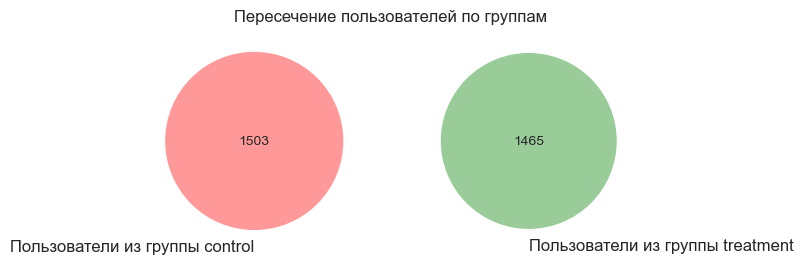

In [84]:
#Создадим множества для диаграммы Венна на основе уникальных id пользователя
users_control = set(users_split[users_split['group'] == 'control']['user_id'].unique())
users_treatment = set(users_split[users_split['group'] == 'treatment']['user_id'].unique())

#Строим диаграмму Венна для поиска пересечения пользователей
venn2([users_control, users_treatment], set_labels = ['Пользователи из группы control', 'Пользователи из группы treatment'])
plt.title('Пересечение пользователей по группам')
plt.show()

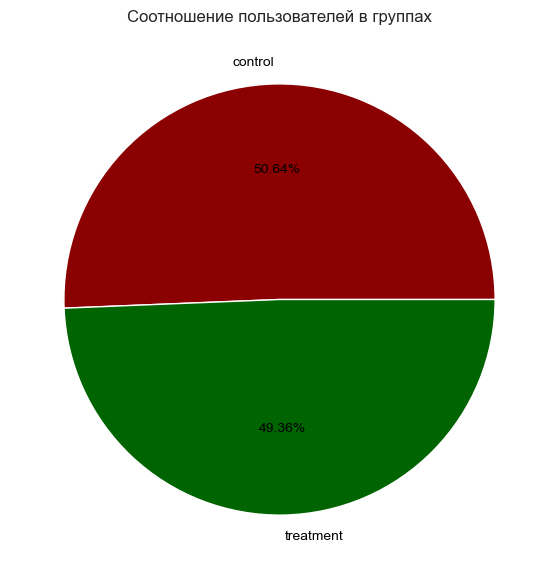

Разница пользователей в группах составляет - 2.5%


In [85]:
colors = ['darkred', 'darkgreen']

#Построим график соотношения групп
count_user_ab = users_split.groupby('group')['user_id'].nunique()
plt.figure(figsize = (7,7))
plt.pie(count_user_ab, labels=count_user_ab.index, autopct='%.2f%%', colors=colors, textprops={'color': 'black'})
plt.title('Соотношение пользователей в группах')
plt.show()

#Рассчитаем разницу между пользователями групп
count_diff = round(100 * ((len(users_control) - len(users_treatment))/ len(users_control)), 1)
print(f'Разница пользователей в группах составляет - {count_diff}%')

Посмотрим на распределение набора новых пользователей в группы эксперимента (не кумулятивное):

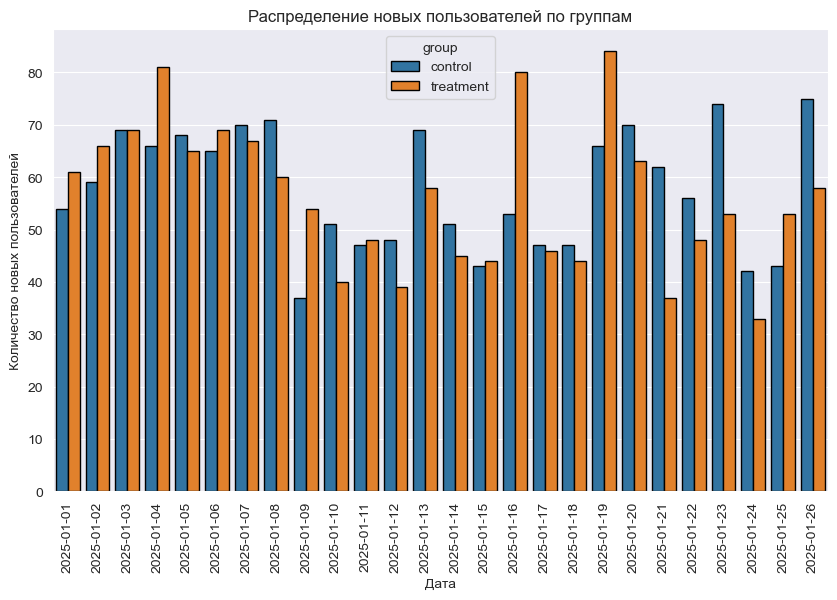

In [86]:
#Приведем дату регистрации к формату `yyyy-mm-dd` и сгруппируем пользователей по дате и группе
users_split_group = users_split.copy()
users_split_group['registration_date'] = users_split_group['registration_date'].dt.strftime('%Y-%m-%d')
users_split_group = users_split_group.groupby(['registration_date', 'group'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'count_users'})

#Строим гистограмму распределения новых пользователей по группам
plt.figure(figsize=(10, 6))
sns.barplot(data=users_split_group,x='registration_date', y='count_users', hue='group', edgecolor='k')
plt.title('Распределение новых пользователей по группам')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Количество новых пользователей')
plt.show()

Не сказать, что сплитование было равномерным, но разница между группами небольшая.

### Промежуточный вывод по предобработке данных эксперимента

- датафрейм с информацией о пользователях `users_ab` отфильтровали по участникам эксперимента с помощью `split_users`, рабочий датафрейм теперь под названием `users_split`. Дубликатов и пропусков нет, уникальных пользователей - 2968, канал привлечения `TikTok`, диапазон дат регистраций c 1 по 26 января 2025 года. Названия групп эксперимента - 'control' и 'treatment'.

- датафрейм `orders_ab` был отфильтрован по заказам пользователей эксперимента (по `users_split`) и называется теперь `orders_split`. Количество уникальных покупателей - 126, пропусков и дубликатов не имеется. Интервал дат - с 1 по 26 января 2025 года. Была проведена отдельная работа с типом данных столбца `order_date`.

- датафрейм `events_ab` также был очищен только по событиям пользователей эксперимента и называется теперь `events_split`.  Количество уникальных пользователей - 490, дубликатов нет, есть пропуски в столбце `product_name`, заполнять их не обязательно, на аналитическую работу эти пропуски не повлияют. Интервал дат в датафрейме events_split: 02-01-2025 03:25:32 - 26-01-2025 23:46:15, что вероятнее всего говорит *об ошибках в логировании действий пользователей в начале эксперимента*, т.к. заказы оформлялись уже с 1 января.

- датафрейм `sessions_ab` был отфильтрован по сессиям пользователей из эксперимента и называется теперь `sessions_split`. Пропусков и дубликатов нет, была проведена отдельная работа с типом данных столбца `session_start`. Интервал дат в датафрейме sessions_split:  02-01-2025  03:24:57 -  26-01-2025  23:43:27, вероятны *ошибки в логировании сессий пользователей*, т.к. заказы от зарегистрированных пользователей оформлялись с 1 января.

- пересечений в группах пользователей 'control' и 'treatment' нет. Количество зарегистрировавшихся пользователей в 'control' - 1503, в 'treatment' - 1465, разница составляет 2,5%
-----


## Анализ метрик А/В-эксперимента "*Бонус на первую покупку для пользователей TikTok*"

- **Продкутовая гипотеза:** Предоставление бонуса на первую покупку новым пользователям, привлеченным через TikTok, приведет к увеличению конверсии в первую покупку
- **Период проведения:** 3 недели (фиксировано)

Проанализируем такие метрики:
1) **Основная метрика**
- *Конверсия в первую покупку* — доля пользователей, зарегистрировавшихся с TikTok и совершивших первую покупку

2) **Барьерная метрика**
- *Общая выручка от пользователей TikTok*

3) **Вспомогательные метрики**
- *ARPU* (средняя выручка на пользователя TikTok)
- *ARPPU* (средняя выручка на покупателя TikTok)
- *AOV* (средний чек TikTok)


### Ключевая метрика - *Конверсия в первую покупку*

Рассчитаем ключевую метрику для контрольной и тестовой группы, а также их абсолютную и относительную разницу.
В качестве статистического критерия применим z-тест, так как сравниваются пропорции групп.

Сформулируем гипотезы:

**Нулевая гипотеза**: конверсия в первую покупку для зарегистрировавшихся пользователей с TikTok в группах не изменилась.

**Альтернативная гипотеза**: конверсия в первую покупку для зарегистрировавшихся пользователей с TikTok в группах изменилась.

Но перед тем, как использовать z-тест пропорций, нам необходимо убедиться, что размер каждой из групп достаточный. Эта предпосылка важна для корректного применения ЦПТ, для которой требуется достаточное количество наблюдений.

Период проведения обозначили в 3 недели, соответственно если данных будет достаточно, будем анализировать данные за 21 день, вместо 26 дней, которые нам предоставили (с 1 по 21 января 2025 года).

In [87]:
#Обозначим крайнюю дату теста (21 день)
max_date_21 = '2025-01-22'
#Подготовим зарегистрировавшихся пользователей
users_reg_21 = users_split[users_split['registration_date'] < max_date_21]
users_reg_21['registration_date'] = users_reg_21['registration_date'].dt.normalize()
users_reg_21 = users_reg_21.groupby(['group', 'registration_date'])['user_id'].nunique().reset_index()

#Подготовим покупателей
orders_21 = orders_split[orders_split['order_date'] < max_date_21]
orders_21['order_date'] = orders_21['order_date'].dt.normalize()
#Вычислим дату первого заказа
first_order_21 = orders_21.groupby('user_id')['order_date'].min().reset_index().rename(columns={'order_date': 'first_order_date'})
#Присоединим группу
first_order_21 = pd.merge(first_order_21, users_split[['user_id', 'group']], on='user_id', how='left')
#Посчитаем покупателей
first_order_21 = first_order_21.groupby(['group', 'first_order_date'])['user_id'].nunique().reset_index()

#Создадим функцию для подсчета размера групп и вывода предпосылки
def group_count(df_1, df_2):
    #Подсчет количества пользователей групп
    n_control = df_1[df_1['group']== 'control']['user_id'].sum()
    n_treatment = df_1[df_1['group']== 'treatment']['user_id'].sum()
    print(f'Количество зарегистрировавшихся пользователей группы control - {n_control}, группы treatment - {n_treatment}.')

    #Количество покупателей групп
    m_control = df_2[df_2['group']== 'control']['user_id'].sum()
    m_treatment = df_2[df_2['group']== 'treatment']['user_id'].sum()
    print(f'Количество покупателей группы control - {m_control}, группы treatment - {m_treatment}.')

    #Доли конверсий каждой из групп
    p_control, p_treatment = m_control/n_control, m_treatment/n_treatment
    print(f'Доли группы control - {p_control}, группы treatment - {p_treatment}.')

    #Проверка условий для Z-теста пропорций
    if (p_control * n_control > 10) and ((1 - p_control) * n_control > 10) and \
       (p_treatment * n_treatment > 10) and ((1 - p_treatment) * n_treatment > 10):
        print('Предпосылка о достаточном количестве данных выполняется.')
    else:
        print('Предпосылка о достаточном количестве данных не выполняется.')

#Применим функцию для эксперимента длительностью в 21 день
group_count(users_reg_21, first_order_21)


Количество зарегистрировавшихся пользователей группы control - 1213, группы treatment - 1220.
Количество покупателей группы control - 10, группы treatment - 83.
Доли группы control - 0.008244023083264633, группы treatment - 0.0680327868852459.
Предпосылка о достаточном количестве данных не выполняется.


Исходя из 21 дня эксперимента, полученных данных оказалось недостаточно для применения z-теста пропорций. Но так как тест проводили 26 дней, мы можем пересчитать данные выборок на этот срок.

In [88]:
#Обозначим крайнюю дату теста (26 дней)
max_date_26 = '2025-01-27'
#Подготовим зарегистрировавшихся пользователей
users_reg_26 = users_split[users_split['registration_date'] < max_date_26]
users_reg_26['registration_date'] = users_reg_26['registration_date'].dt.normalize()
users_reg_26 = users_reg_26.groupby(['group', 'registration_date'])['user_id'].nunique().reset_index()

#Подготовим покупателей
orders_26 = orders_split[orders_split['order_date'] < max_date_26]
orders_26['order_date'] = orders_26['order_date'].dt.normalize()
#Вычислим дату первого заказа
first_order_26 = orders_26.groupby('user_id')['order_date'].min().reset_index().rename(columns={'order_date': 'first_order_date'})
#Присоединим группу
first_order_26 = pd.merge(first_order_26, users_split[['user_id', 'group']], on='user_id', how='left')
#Посчитаем покупателей
first_order_26 = first_order_26.groupby(['group', 'first_order_date'])['user_id'].nunique().reset_index()

#Применим функцию для эксперимента длительностью в 26 дней
group_count(users_reg_26, first_order_26)

Количество зарегистрировавшихся пользователей группы control - 1503, группы treatment - 1465.
Количество покупателей группы control - 16, группы treatment - 110.
Доли группы control - 0.010645375914836993, группы treatment - 0.07508532423208192.
Предпосылка о достаточном количестве данных выполняется.


Теперь можем перейти к самому тесту:

In [89]:
#Пустой список для результатов теста
results_conversion = []

control_registration = users_reg_26[users_reg_26['group']=='control']['user_id'].sum()
treatment_registration = users_reg_26[users_reg_26['group']=='treatment']['user_id'].sum()
control_first_purchase = first_order_26[first_order_26['group']== 'control']['user_id'].sum()
treatment_first_purchase = first_order_26[first_order_26['group']=='treatment']['user_id'].sum()

#Подготовка данных для z-теста
first_purchase = np.array([control_first_purchase, treatment_first_purchase])
registration = np.array([control_registration, treatment_registration])

#Z-тест для двух пропорций
z_stat, p_value = proportions_ztest(first_purchase, registration, alternative='two-sided')

#Расчет конверсий и разницы
control_conv = first_purchase[0] / registration[0]
treatment_conv = first_purchase[1] / registration[1]

#Добавим результаты
results_conversion.append({
    'p_value': p_value,
    'control_conversion_%': round(control_conv * 100, 1),
    'test_conversion_%': round(treatment_conv * 100, 1),
    'absolute lift': round((treatment_conv - control_conv), 2),
    'relative lift (%)': round(((treatment_conv / control_conv - 1) * 100), 2)
})

#Создадим DataFrame
conversion_df = pd.DataFrame(results_conversion)

print('Результаты сравнения основной метрики для групп:')
display(conversion_df)

if conversion_df['p_value'].iloc[0] >= 0.05:
    print(f'Нулевая гипотеза находит подтверждение.\n'
          f'Результат не является статистически значим. Конверсия в первую покупку для зарегистрировавшихся пользователей с TikTok в группах не изменилась.')
else:
    print(f'Нулевая гипотеза не находит подтверждения.\n'
          f'Результат статистически значим. Конверсия в первую покупку для зарегистрировавшихся пользователей с TikTok в группах изменилась.')

Результаты сравнения основной метрики для групп:


,p_value,control_conversion_%,test_conversion_%,absolute lift,relative lift (%)
0,3.164906e-18,1.1,7.5,0.06,605.33


Нулевая гипотеза не находит подтверждения.
Результат статистически значим. Конверсия в первую покупку для зарегистрировавшихся пользователей с TikTok в группах изменилась.


#### Промежуточный вывод по основной метрике
При расчете конверсии в первую покупку для зарегистрировавшихся пользователей с канала TikTok использовались данные за 26 дней. Данных по выборкам за 21 день не хватало для корректного проведения z-теста пропорций (предпосылка о достаточном количестве данных не выполнялась). По результатам эксперимента получены следующие результаты:
- обнаружено статистически значимые различия в конверсии между группами (p-value < 0,05);
- наблюдается тенденция роста конверсии в первую покупку в тестовой группе (+600%) по сравнению с контрольной;
- в результате введения бонуса на первую покупку, часть пользователей стала чаще конвертироваться в первую покупку после регистрации.

### Барьерная метрика - *общая выручка от пользователей TikTok*
Так как основную метрику считали за 26 дней, то и остальные метрики посчитаем за этот же период

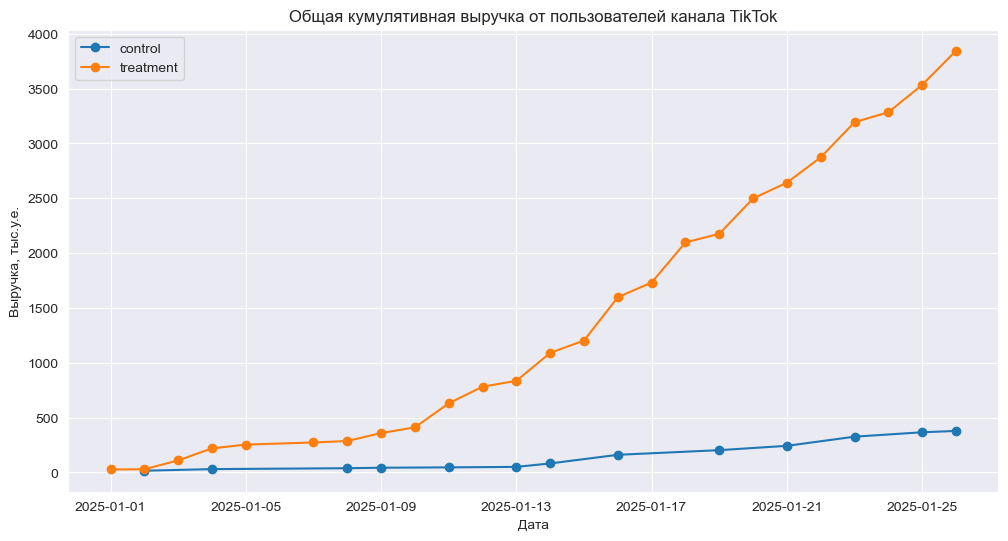

In [90]:
#Объединим заказы с группой пользователей
users_orders_26_days = pd.merge(orders_split, users_split[['user_id', 'group']], how='left', on='user_id')

# #Отфильтруем данные заказа по дате
# users_orders_26_days = users_orders_merge[users_orders_merge['order_date'] < max_date_26]

#Приведем столбец с датой заказа к формату yyyy-mm-dd
users_orders_26_days['order_date'] = users_orders_26_days['order_date'].dt.normalize()

#Посчитаем выручку по датам и группам
revenue_26_days = users_orders_26_days.groupby(['group', 'order_date']).agg({'total_price': 'sum'}).reset_index()

#Сортируем для вычисления кумулятивной суммы
revenue_26_days = revenue_26_days.sort_values(['group', 'order_date'])

#Вычисляем кумулятивную сумму пользователей по группам
revenue_26_days['cumul_sum'] = revenue_26_days.groupby(['group'])['total_price'].cumsum()

#Строим график через цикл
plt.figure(figsize=(12,6))

for group in revenue_26_days['group'].unique():
    revenue_26_days_df = revenue_26_days[revenue_26_days['group']== group]
    plt.plot(revenue_26_days_df['order_date'], revenue_26_days_df['cumul_sum']/1000, marker='o', label=f'{group}')

plt.title('Общая кумулятивная выручка от пользователей канала TikTok')
plt.xlabel('Дата')
plt.ylabel('Выручка, тыс.у.е.')
plt.legend()
plt.grid(True)
plt.show()


#### Промежуточный вывод по барьерной метрике

Как видно из графика общей выручки от пользователей TikToK, в группе `treatment` выручка больше (3845 тыс.у.е.) к концу 26 дня эксперимента, чем у группы `control` (379 тыс.у.е.).

### Вспомогательные метрики

- *ARPU* (средняя выручка на пользователя TikTok)

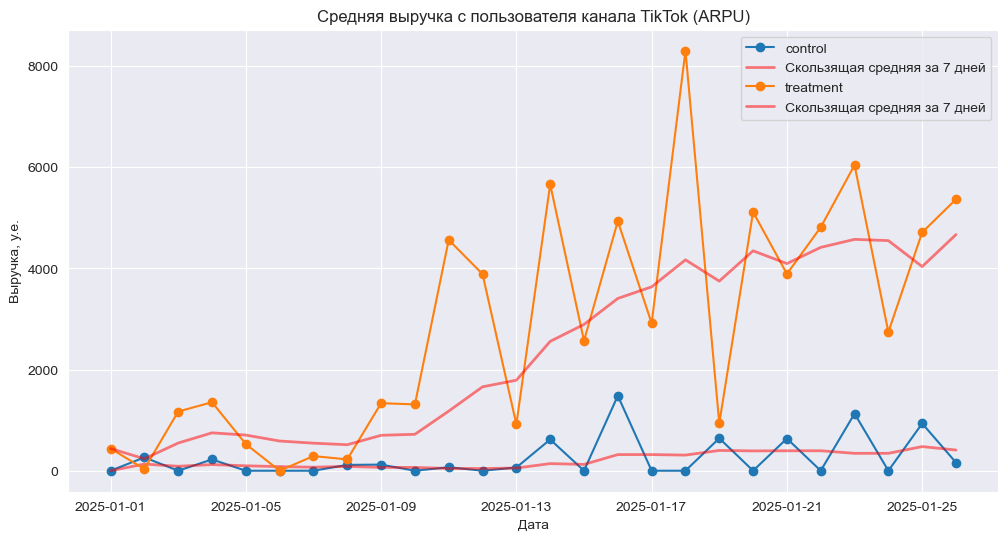

Результаты сравнения вспомогательной метрики ARPU для групп:


,avg_arpu_control,avg_arpu_treatment,absolute_lift,"relative_lift, %"
0,248.46,2848.97,2600.51,1046.63


In [91]:
#Считаем пользователей с канала TikTok по дням
users_26_days = users_split.copy()
#Приведем дату регистрации к формату yyyy-mm-dd
users_26_days['registration_date'] = users_26_days['registration_date'].dt.normalize()
# #Отфильтруем данные регистрации по дате окончания теста
# users_26_days = users_26_days[users_26_days['registration_date'] < max_date]

#Посчитаем количество пользователей за каждый день по группам
users_26_days = users_26_days.groupby(['group', 'registration_date'])['user_id'].nunique().reset_index()

#Присоединим к пользователям с заказами их группу
users_revenue_26_days = pd.merge(orders_split, users_split[['user_id', 'group']], how='left', on='user_id')
users_revenue_26_days['order_date'] = users_revenue_26_days['order_date'].dt.normalize()
# users_revenue_26_days = users_revenue_26_days[users_revenue_26_days['order_date'] < max_date_26]

#Посчитаем выручку с пользователей группы по дням
users_revenue_26_days = users_revenue_26_days.groupby(['group', 'order_date'])['total_price'].sum().reset_index().rename(columns={'total_price': 'revenue'})

#Объединим пользователей с выручкой от них по дате и группе
arpu_ab = pd.merge(users_26_days, users_revenue_26_days, left_on = ['registration_date', 'group'], right_on = ['order_date', 'group'], how='left' )

# Заполняем пропуски в выручке нулями (если в какой-то день не было заказов)
arpu_ab['revenue'] = arpu_ab['revenue'].fillna(0)

#Посчитаем метрику средней выручки с пользователя  TikTok
arpu_ab['arpu'] = arpu_ab['revenue'] / arpu_ab['user_id']

#Строим график через цикл
plt.figure(figsize=(12,6))

for group in arpu_ab['group'].unique():
    arpu_ab_df = arpu_ab[arpu_ab['group']== group]
    plt.plot(arpu_ab_df['registration_date'], arpu_ab_df['arpu'], marker='o', label=f'{group}')

    #Рассчитаем скользящую среднюю за 7 дней для сглаживания графика
    arpu_ab_mean = arpu_ab_df['arpu'].rolling(window=7, min_periods=1).mean()

    #Добавим скользящую среднюю на график
    plt.plot(arpu_ab_df['registration_date'], arpu_ab_mean, label='Скользящая средняя за 7 дней', alpha=0.5, linewidth=2, color='red')

plt.title('Средняя выручка с пользователя канала TikTok (ARPU)')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.legend()
plt.grid(True)
plt.show()

#Создадим список для хранения результатов
results_arpu = []

#Подготовим данные для расчета средних
avg_for_user_c = arpu_ab[arpu_ab['group'] == 'control']['arpu'].mean()
avg_for_user_t = arpu_ab[arpu_ab['group'] == 'treatment']['arpu'].mean()

absolute_lift = avg_for_user_t - avg_for_user_c
relative_lift = 100 * ((avg_for_user_t - avg_for_user_c) / avg_for_user_c)

# Добавляем результаты в список
results_arpu.append({
    'avg_arpu_control': avg_for_user_c.round(2),
    'avg_arpu_treatment': avg_for_user_t.round(2),
    'absolute_lift': absolute_lift.round(2),
    'relative_lift, %': relative_lift.round(2)
})

#Создадим DataFrame из результатов
results_arpu_df = pd.DataFrame(results_arpu)
print('Результаты сравнения вспомогательной метрики ARPU для групп:')
display(results_arpu_df)

#### Промежуточный вывод по барьерной метрике ARPU

Как видно из графика средней выручки с пользователя канала TikTok (ARPU), средняя выручка для группы `treatment` больше, чем для группы `control`. Метрика для группы `treatment` достигает в среднем 2848 у.е., для группы `control` - 248 у.е, относительная разница составляет около 1046%.

- *ARPPU* (средняя выручка на покупателя TikTok)

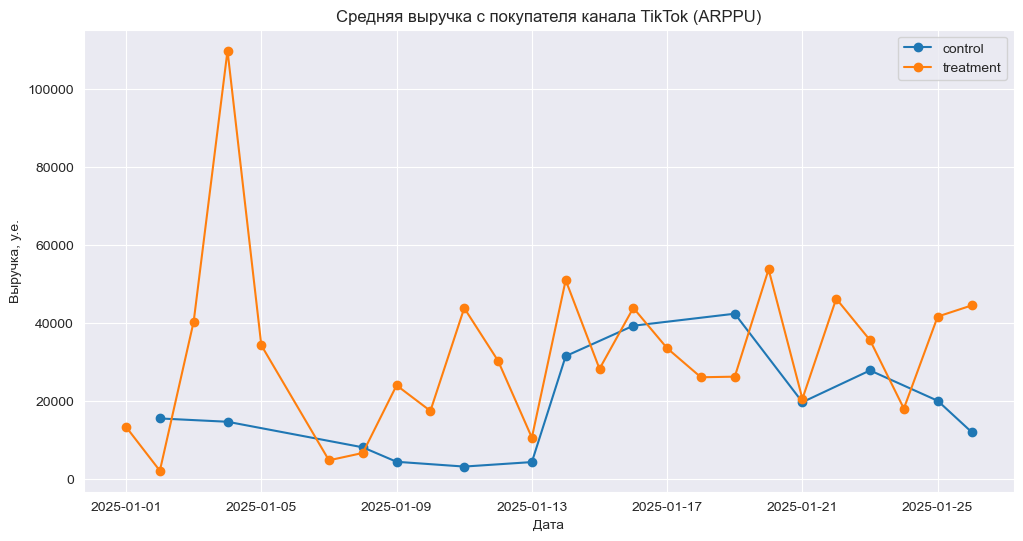

Результаты сравнения вспомогательной метрики ARPPU для групп:


,avg_arppu_control,avg_arppu_treatment,absolute_lift,"relative_lift, %"
0,18733.58,32286.05,13552.47,72.34


In [92]:
#Присоединим к пользователям с заказами их группу
buyers_26_days = pd.merge(orders_split, users_split[['user_id', 'group']], how='inner', on='user_id')
#Приведем дату заказа к формату yyyy-mm-dd
buyers_26_days['order_date'] = buyers_26_days['order_date'].dt.normalize()
# #Отфильтруем данные заказов по дате окончания теста
# buyers_26_days = buyers_26_days[buyers_26_days['order_date'] < max_date_26]

#Посчитаем количество покупателей за каждый день по группам
users_buyers_26_days= buyers_26_days.groupby(['group', 'order_date'])['user_id'].nunique().reset_index().rename(columns={'user_id': 'count_buyers'})

#Посчитаем выручку с покупателей группы по дням
revenue_buyers_26_days = buyers_26_days.groupby(['group', 'order_date'])['total_price'].sum().reset_index().rename(columns={'total_price': 'revenue'})

#Объединим покупателей с выручкой от них по дате и группе
arppu_ab = pd.merge(users_buyers_26_days, revenue_buyers_26_days, on = ['order_date', 'group'] )

#Посчитаем метрику средней выручки с покупателя с канала TikTok
arppu_ab['arppu'] = arppu_ab['revenue'] / arppu_ab['count_buyers']

#Строим график через цикл
plt.figure(figsize=(12,6))

for group in arppu_ab['group'].unique():
    arppu_ab_df = arppu_ab[arppu_ab['group']== group]
    plt.plot(arppu_ab_df['order_date'], arppu_ab_df['arppu'], marker='o', label=f'{group}')

plt.title('Средняя выручка с покупателя канала TikTok (ARPPU)')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.legend()
plt.grid(True)
plt.show()

#Создадим список для хранения результатов
results_arppu = []

#Подготовим данные для расчета средних
avg_for_buyer_c = arppu_ab[arppu_ab['group'] == 'control']['arppu'].mean()
avg_for_buyer_t = arppu_ab[arppu_ab['group'] == 'treatment']['arppu'].mean()

absolute_lift = avg_for_buyer_t - avg_for_buyer_c
relative_lift = 100 * ((avg_for_buyer_t - avg_for_buyer_c) / avg_for_buyer_c)

# Добавляем результаты в список
results_arppu.append({
    'avg_arppu_control': avg_for_buyer_c.round(2),
    'avg_arppu_treatment': avg_for_buyer_t.round(2),
    'absolute_lift': absolute_lift.round(2),
    'relative_lift, %': relative_lift.round(2)
})

#Создадим DataFrame из результатов
results_arppu_df = pd.DataFrame(results_arppu)
print('Результаты сравнения вспомогательной метрики ARPPU для групп:')
display(results_arppu_df)

#### Промежуточный вывод по барьерной метрике ARPPU

Как видно из графика средней выручки с покупателя с канала TikTok (ARPPU), средняя выручка для группы `treatment` больше, чем для группы `control`. Метрика для группы `treatment` достигает в среднем 32 тыс. у.е., для группы `control` - 18 тыс. у.е., относительная разница между группами составляет примерно 72%.

- *AOV* (средний чек TikTok)

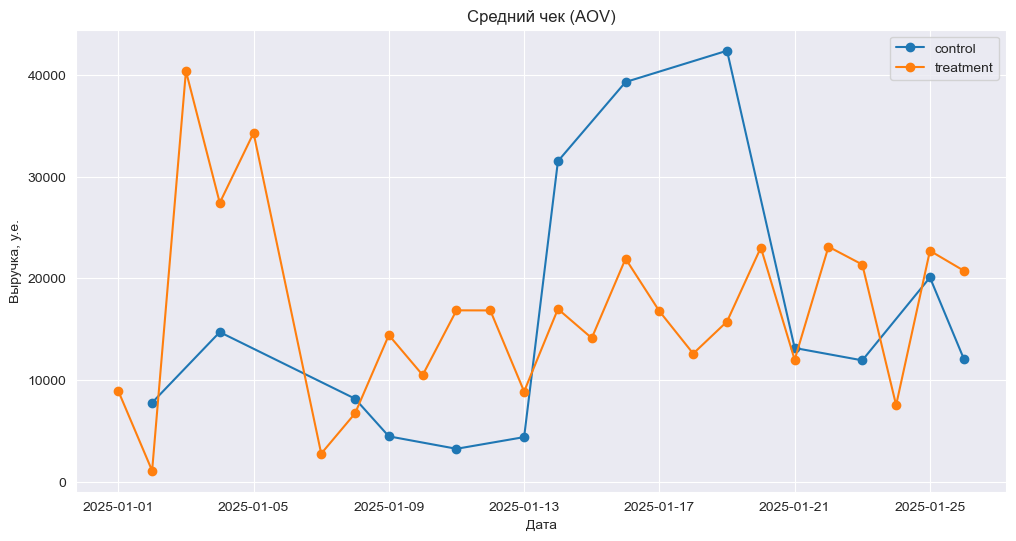

Результаты сравнения вспомогательной метрики AOV для групп:


,avg_aov_control,avg_aov_treatment,absolute_lift,"relative_lift, %"
0,16404.51,16711.21,306.69,1.87


In [93]:
#Присоединим к пользователям с заказами их группу
aov_ab = pd.merge(orders_split, users_split[['user_id', 'group']], how='inner', on='user_id')

#Приведем дату заказа к формату yyyy-mm-dd
aov_ab['order_date'] = aov_ab['order_date'].dt.normalize()
aov_ab = aov_ab.groupby(['group', 'order_date']).agg(
    total_revenue = ('total_price', 'sum'),
    count_order = ('order_id', 'count')
).reset_index()

aov_ab['aov'] = aov_ab['total_revenue'] / aov_ab['count_order']

#Строим график через цикл
plt.figure(figsize=(12,6))

for group in aov_ab['group'].unique():
    aov_ab_df = aov_ab[aov_ab['group']== group]
    plt.plot(aov_ab_df['order_date'], aov_ab_df['aov'], marker='o', label=f'{group}')

plt.title('Средний чек (AOV)')
plt.xlabel('Дата')
plt.ylabel('Выручка, у.е.')
plt.legend()
plt.grid(True)
plt.show()

#Создадим список для хранения результатов
results_aov = []

#Подготовим данные для расчета средних
avg_check_c = aov_ab[aov_ab['group'] == 'control']['aov'].mean()
avg_check_t = aov_ab[aov_ab['group'] == 'treatment']['aov'].mean()

absolute_lift = avg_check_t - avg_check_c
relative_lift = 100 * ((avg_check_t - avg_check_c) / avg_check_c)

#Добавляем результаты в список
results_aov.append({
    'avg_aov_control': avg_check_c.round(2),
    'avg_aov_treatment': avg_check_t.round(2),
    'absolute_lift': absolute_lift.round(2),
    'relative_lift, %': relative_lift.round(2)
})

#Создадим DataFrame из результатов
results_aov_df = pd.DataFrame(results_aov)
print('Результаты сравнения вспомогательной метрики AOV для групп:')
display(results_aov_df)

#### Промежуточный вывод по барьерной метрике AOV

Как видно из графика среднего чека от покупателя с канала TikTok (AOV), средний чек для группы `treatment` больше, чем для группы `control`. Метрика для группы `treatment` достигает в среднем 16700 у.е., для группы `control` - 16400 у.е., относительная разница между группами составляет примерно 1,8%.

## Вывод по блоку "Подготовка эксперимента и подведение его результатов"

Эксперимент по предоставлению бонуса на первую покупку пользователям с канала TikTok показал положительный эффект. Однако отсутствие предварительного расчета мощности теста, MDE и требуемого размера выборки сказался на возможности подведения итогов статистического теста в требуемый период (3 недели) из-за недостаточности данных по выборкам. Расчет проводился на всех предоставленных данных за 26 дней и позволил получить статистически значимые результаты.

1) **Основная метрика** - конверсия в первую покупку для зарегистрировавшихся пользователей с канала TikTok.

- обнаружено статистически значимые различия в конверсии между группами (p-value < 0,05);
- конверсия выросла с 1.1% до 7.5% (+6.4 п.п., относительный рост +600%);
- в результате введения бонуса на первую покупку, часть пользователей стала чаще конвертироваться в первую покупку после регистрации.

2) **Барьерная метрика** - общая выручка от пользователей TikToK

- тестовая группа принесла в 10 раз больше выручки (3845 тыс.у.е. против 379 тыс.у.е.), чем контрольная;
- финансовый стимул увеличил не только конверсию в первую покупку, но и значительно повысил общую выручку.

3) **Вспомогательная метрика** - средняя выручка с пользователя канала TikTok (ARPU)

- каждый пользователь тестовой группы приносит в среднем 2848 у.е. против 248 у.е. в контрольной группе.

4) **Вспомогательная метрика** - средняя выручка с покупателя с канала TikTok (ARPPU)

- каждый покупатель тестовой группы в среднем приносит 32 тыс.у.е. против 18 тыс.у.е. в контрольной группе.


5) **Вспомогательная метрика** - средний чек покупателя с канала TikTok (AOV)

- средний чек пользователя в тестовой группе в среднем 16700 у.е., в контрольной - 16400 у.е.
- бонус за покупку практически не влияет на размер среднего чека.

Бонус повлиял на конверсию пользователей в первую покупку, увеличил общую выручку и количество покупателей, но не повлиял на размер среднего чека. Бонусную программу можно внедрить на постоянной основе только если она оправдывает затраты на такую акцию (данных для расчета по затратам отсутствовали).

Рекомендации:
1) Необходимо проанализировать метрики unit-экономики по пользователям TikTok с учетом стоимости бонусов, т.к. выручка с пользователей по бонусной программы может не окупать затраты.
2) Оценить в долгосрочной перспективе Retention Rate в повторную покупку, т.к. подобные акции провоцируют пользователей на первую покупку из-за ощущения выгодоной сделки. В повторную покупку они могут не вернуться.

